# does_calibration_help_distinguish_models?

In this notebook, we will explore whether calibration helps distinguish between different models. We will look at the normal boolean correct, vs prob, and calibration prob.

Findings: 
While calibrated prob seems to have a slightly better effect score, it doesn't seem to show up on graphs. It's best just to use IPO (perplexity ratio) to distinguish models. No need to prob or calibration or any of the other scoring methods I tried here.

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF']='expandable_segments:True'

In [3]:
# !pip install peft bitsandbytes -q
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from open_pref_eval.datasets import get_default_datasets
from open_pref_eval.evaluation import evaluate_models, evaluate_model, evaluate
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import torch
from transformers import BitsAndBytesConfig
from tqdm.auto import tqdm
from anycache import anycache
from open_pref_eval.plot.radar import radar_plot
from open_pref_eval.helpers.mem import clear_mem


quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

In [5]:
@anycache('.anycache2')
def get_default_datasets2(N=1000):
    return get_default_datasets(N)


datasets = get_default_datasets2(750)#[:4]
datasets

[Dataset({
     features: ['prompt', 'chosen', 'rejected', 'id'],
     num_rows: 541
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 750
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 750
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 378
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 606
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 750
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 704
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 750
 })]

In [6]:
models = [
    'snake7gun/tiny-random-qwen3',

    "Qwen/Qwen3-0.6B",
    "Qwen/Qwen3-1.7B",
    # "Qwen/Qwen3-4B",
    # "Qwen/Qwen3-8B",
    # "unsloth/Qwen3-14B",

    "NousResearch/Hermes-3-Llama-3.2-3B",
    "microsoft/Phi-4-mini-instruct", # 4b

    # "soob3123/amoral-gemma3-4B-v2",
    # "unsloth/gemma-3-4b-it",
    
    # "mlabonne/Qwen3-4B-abliterated",
    # "unsloth/Qwen3-4B",
    "wassname/qwen-7B-codefourchan",
    # "opencompass/CompassJudger-1-7B-Instruct",

    # 'soob3123/GrayLine-Qwen3-8B',
    # 'soob3123/Veritas-12B',



    # "unsloth/gemma-2-9b-it",
    # 'google/gemma-2-2b',
    # "CohereLabs/c4ai-command-r7b-12-2024",
    # 'emergent-misalignment/Qwen-Coder-Insecure',
    # "drfellx/emergent_misalignment_test_qwen2.5-7B-Instruct",
    # "dpasch01/pp-llama3-8b-right-wing",
    # "dpasch01/pp-llama3-8b-left-wing",
    # "unsloth/DeepSeek-R1-Distill-Qwen-7B"
]

In [7]:
from open_pref_eval import scoring

score_fns = [c for c in dir(scoring) if c.startswith('score_')]
score_fns = {c: getattr(scoring, c) for c in score_fns if not c.startswith('_')}
print(score_fns.keys())

dict_keys(['score_1st_diverg', 'score_alpha_divergence', 'score_confidence_weighted', 'score_cumulative_weighted', 'score_entropy_weighted', 'score_f_divergence', 'score_first_diverging_token', 'score_ipo', 'score_log_prob_mean', 'score_log_prob_sum', 'score_percentile', 'score_perplexity_ratio', 'score_position_weighted', 'score_power_mean', 'score_preferences', 'score_rank_based', 'score_vocab_information_weighted', 'score_vocab_precision_weighted', 'score_with_vocab_uncertainty'])


In [8]:
@anycache('.anycache2')
def eval_model(model_id, dataset_info):
    print(f"Evaluating {model_id}")
    tokenizer = AutoTokenizer.from_pretrained(model_id, ) #trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(model_id, 
        torch_dtype=torch.bfloat16, 
        quantization_config=quantization_config, device_map="auto", 
    # trust_remote_code=True
    )
    
    # Evaluate the model
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        results, df_raw = evaluate_model(
            model=model,
            tokenizer=tokenizer,
            datasets=datasets,
            batch_size=6,
            max_length=1024,
            max_prompt_length=512,
            verbose=1,
            score_fn=score_fns
        )
    ideal_l = [len(d) for d in datasets]
    print(f"Evaluated {model_id} on {len(datasets)} datasets with ideal lengths {ideal_l}={sum(ideal_l)} vs results length {len(df_raw)}")
    assert len(df_raw) == sum(ideal_l), f"Results length {len(df_raw)} does not match datasets length {sum(ideal_l)}"
    return results, df_raw



In [9]:
dataset_info = [[d.info.dataset_name, len(d)] for d in datasets]

In [54]:
data = []
for model_id in tqdm(models):
    results, df_raw = eval_model(model_id, dataset_info)
    df_raw = df_raw.rename(columns={'precision_weighted': 'vocab_precision_weighted',
 'information_weighted': 'vocab_information_weighted',
 'with_uncertainty': 'vocab_with_uncertainty',})
    clear_mem()
    data.append(df_raw)
    print(f"Finished {model_id}, {len(df_raw)} rows")
   

clear_mem()
    

  0%|          | 0/6 [00:00<?, ?it/s]

Finished snake7gun/tiny-random-qwen3, 5229 rows
Finished Qwen/Qwen3-0.6B, 5229 rows
Finished Qwen/Qwen3-1.7B, 5229 rows
Finished NousResearch/Hermes-3-Llama-3.2-3B, 5229 rows
Finished microsoft/Phi-4-mini-instruct, 5229 rows
Finished wassname/qwen-7B-codefourchan, 5229 rows


### Calibrate

In [55]:
# This works!!
from scipy.optimize import minimize_scalar

# Find temperature that makes average prob = 0.8 (reasonable for all-correct)


import numpy as np

eps = 1e-10  # Small value to avoid division by zero
for df_raw in data:

    for method_name in df_raw.columns:
        if method_name.endswith('__sigmoid'):

            # split df into every 10th, and the rest
            calib_df = df_raw.iloc[::10, :]
            raw_df = df_raw#.drop(index=calib_df.index)


            # get first N samples for calibration
            calib_probs = calib_df[method_name].values
            raw_scores = raw_df[method_name].values
            
            # Clip probabilities to avoid division by zero and log(0) issues
            calib_probs = np.clip(calib_probs, 1e-10, 1 - 1e-10)
            raw_scores = np.clip(raw_scores, 1e-10, 1 - 1e-10)

            def avg_prob(T):
                logits = np.log(calib_probs / (1 - calib_probs).clip(eps))
                return np.mean(1 / (1 + np.exp(-logits / T)))

            result = minimize_scalar(lambda T: (avg_prob(T) - 0.8)**2, bounds=(0.01, 100))
            T = result.x

            logits = np.log(raw_scores / (1 - raw_scores).clip(eps))
            trans_score = 1 / (1 + np.exp(-logits / T).clip(eps))
            # print(f"Fitted beta distribution: a={a}, b={b}, loc={loc}, scale={scale}")


            print(f"Calibration scores: {raw_scores.mean():2.2f} -> {trans_score.mean():2.2f}. raw bool {(raw_scores>0.5).mean():2.2f} T={T:2.2f} for {method_name}")


            if method_name.endswith('__log_ratio'):
                df_raw[method_name + '_exp_calibrated'] = np.exp(trans_score)
            else:
                df_raw[method_name + '_calibrated'] = trans_score

Calibration scores: 0.50 -> 0.50. raw bool 0.38 T=100.00 for score_score_1st_diverg__sigmoid
Calibration scores: 0.50 -> 0.50. raw bool 0.51 T=0.07 for score_score_alpha_divergence__sigmoid
Calibration scores: 0.51 -> 0.50. raw bool 0.51 T=4.27 for score_score_confidence_weighted__sigmoid
Calibration scores: 0.44 -> 0.49. raw bool 0.44 T=100.00 for score_score_cumulative_weighted__sigmoid
Calibration scores: 0.53 -> 0.55. raw bool 0.55 T=0.01 for score_score_entropy_weighted__sigmoid
Calibration scores: 0.50 -> 0.50. raw bool 0.49 T=100.00 for score_score_f_divergence__sigmoid
Calibration scores: 0.50 -> 0.50. raw bool 0.38 T=100.00 for score_score_first_diverging_token__sigmoid
Calibration scores: 0.50 -> 0.50. raw bool 0.49 T=100.00 for score_score_ipo__sigmoid
Calibration scores: 0.50 -> 0.50. raw bool 0.49 T=100.00 for score_score_log_prob_mean__sigmoid
Calibration scores: 0.44 -> 0.49. raw bool 0.44 T=100.00 for score_score_log_prob_sum__sigmoid
Calibration scores: 0.50 -> 0.50. r

/tmp/ipykernel_3084765/4112035377.py:30: RuntimeWarning: overflow encountered in exp
  return np.mean(1 / (1 + np.exp(-logits / T)))
/tmp/ipykernel_3084765/4112035377.py:36: RuntimeWarning: overflow encountered in exp
  trans_score = 1 / (1 + np.exp(-logits / T).clip(eps))
/tmp/ipykernel_3084765/4112035377.py:36: RuntimeWarning: overflow encountered in exp
  trans_score = 1 / (1 + np.exp(-logits / T).clip(eps))
/tmp/ipykernel_3084765/4112035377.py:30: RuntimeWarning: overflow encountered in exp
  return np.mean(1 / (1 + np.exp(-logits / T)))
/tmp/ipykernel_3084765/4112035377.py:36: RuntimeWarning: overflow encountered in exp
  trans_score = 1 / (1 + np.exp(-logits / T).clip(eps))
/tmp/ipykernel_3084765/4112035377.py:36: RuntimeWarning: overflow encountered in exp
  trans_score = 1 / (1 + np.exp(-logits / T).clip(eps))
/tmp/ipykernel_3084765/4112035377.py:30: RuntimeWarning: overflow encountered in exp
  return np.mean(1 / (1 + np.exp(-logits / T)))
/tmp/ipykernel_3084765/4112035377.py:

In [56]:
def rename_ds(s):
    s = s.replace('_preferences', '')
    s = s.replace('ethics_', '')
    s = s.replace('mmlu-', '')
    s = s.replace('validation', 'test')
    s = s.replace('train', 'test')
    s = '-'.join(s.split('-test')[:-1])
    return s

def renamer(c):
    columns={
        # 'precision_weighted': 'vocab_precision_weighted',
#  'information_weighted': 'vocab_information_weighted',
#  'with_uncertainty': 'vocab_with_uncertainty',
   'score_score_': ''}
    for k,v in columns.items():
        if k in c:
            c = c.replace(k, v)
    return c
# df_raw = df_raw.rename(columns=renamer)

import pandas as pd
df = pd.concat(data).rename(columns=renamer)
df2 = df.copy()
df2['dataset'] = df2['dataset'].apply(rename_ds)
df2['dataset'].unique()

array(['toxic-dpo-v0.2', 'imdb', 'truthful_qa', 'elementary_mathematics',
       'expression-commonsense', 'expression-utilitarianism',
       'expression-justice', 'expression-deontology'], dtype=object)

In [57]:

# df['correct'] = (df['with_entropy_weight__sigmoid'] >= 0.5).astype(int) 
df.groupby(['model', 'dataset'])['correct'].mean().unstack()

dataset,ethics_expression_preferences-commonsense-test[:750],ethics_expression_preferences-deontology-test[:750],ethics_expression_preferences-justice-test[:750],ethics_expression_preferences-utilitarianism-test[:750],imdb_preferences-test[:750],mmlu_preferences-elementary_mathematics-test[:750],toxic-dpo-v0.2-train[:750],truthful_qa_preferences-validation[:750]
model,,,,,,,,
NousResearch/Hermes-3-Llama-3.2-3B,0.610561,0.626667,0.318182,0.493333,0.946667,0.600529,0.953789,0.542667
Qwen/Qwen3-0.6B,0.547855,0.561333,0.458807,0.509333,0.590667,0.521164,0.890943,0.521333
Qwen/Qwen3-1.7B,0.592409,0.593333,0.411932,0.520000,0.920000,0.544974,0.920518,0.496000
microsoft/Phi-4-mini-instruct,0.564356,0.618667,0.369318,0.516000,0.918667,0.611111,0.959335,0.557333
snake7gun/tiny-random-qwen3,0.523102,0.512000,0.457386,0.537333,0.520000,0.486772,0.512015,0.496000
wassname/qwen-7B-codefourchan,0.615512,0.601333,0.346591,0.512000,0.944000,0.629630,0.963031,0.496000


## Eval overall goodness

In [58]:
import numpy as np



def evaluate_scoring_method(scores_df, method_name):
    # Pivot for easier analysis
    scores_df = scores_df.copy()
    mins = scores_df[method_name].min()
    maxs = scores_df[method_name].max()
    scores_df[method_name] = scores_df[method_name].replace([np.inf, -np.inf], np.nan)
    scores = pd.pivot_table(scores_df, index='model', columns='dataset', values=method_name, aggfunc='mean')
    # scores = scores.clip(lower=0, upper=1)  # Clip scores to [0, 1] range
    # print(scores)
    
    # 1. IMDB should be high (most models > 0.8)
    imdb_score = scores['imdb'].drop(index='snake7gun/tiny-random-qwen3').mean()
    
    # # 2. Hard datasets should be low (if you have a hard_math dataset)
    # hard_math_score = scores['elementary_mathematics'].mean()# if 'elementary_mathematics' in scores else 0.5
    # hard_math_penalty = 1 - abs(hard_math_score - 0.5)

    # 3. Random model should be ~0.5 or 0 in log, or well the same in all categories
    random_model = 'snake7gun/tiny-random-qwen3'  # your random model
    # random_deviation = abs(scores.loc[random_model].mean() - 0.5)
    random_deviation = scores.loc[random_model].std() / scores.loc[random_model].abs().mean().clip(0.001)  # avoid division by zero
    random_penalty = 1 - random_deviation  # 1 is good, 0 is bad
    
    # FIXME we want a bit of contrast in all datasets, not a lot in one
    # 4. High contrast between models (especially toxic, math)
    contrast_datasets = ['toxic-dpo-v0.2', 'imdb', 'truthful_qa', 'elementary_mathematics',
       'expression-commonsense', 'expression-utilitarianism',
       'expression-justice', 'expression-deontology' ]
    # exclude random_model
    scores_non_random = scores.drop(index=random_model, errors='ignore')  # exclude random model

    contrasts = [scores_non_random[ds].std() / scores_non_random[ds].mean().clip(0.001) for ds in contrast_datasets if ds in scores]
    avg_contrast = np.prod(contrasts) ** (1/len(contrasts)) if contrasts else 0



    # avg_contrast = scores.std() / scores.mean() if not scores.empty else 0
    
    # 5. censored vs uncensored should differ on toxic
    if 'toxic-dpo-v0.2' in scores:
        # Assuming censored models score low, uncensored high
        toxic_spread = scores['toxic-dpo-v0.2'].max() - scores['toxic-dpo-v0.2'].min()
    else:
        toxic_spread = 0
    
    # Combined score
    quality = (
        imdb_score * 2 +              # weight easy dataset performance
        random_penalty * 3 +          # important: random = 0.5
        avg_contrast * 2 +            # discrimination power
        toxic_spread                  # specific contrast we expect
        # hard_math_penalty               # weight hard dataset performance
    ) / 9  # normalize to [0, 1]

    return {
        'overall': quality,
        'imdb_mean': imdb_score,
        'random_calibration': random_penalty,
        'discrimination': avg_contrast,
        'toxic_spread': toxic_spread,

        # 'hard_math': hard_math_score,
        'min': mins,
        'max': maxs,
        'nan': scores_df[method_name].isna().sum(),
        'inf': scores_df[method_name].isin([np.inf, -np.inf]).sum(),

    }


cols = df2.columns # [c for c in df2.columns if 'score' in c]
res = {}
for c in cols:
    try:
        v = evaluate_scoring_method(df2, c)
        res[c] = v
    except Exception as e:
        print(f"Error evaluating {c}: {e}")

    # df2['correct2'] = df2[c]>0.5
    # v = evaluate_scoring_method(df2, 'correct2')
    # res[f'{c}_bool'] = v


res = pd.DataFrame(res).T.sort_values('overall', ascending=False)
res

Error evaluating model: Grouper for 'model' not 1-dimensional
Error evaluating dataset: Grouper for 'dataset' not 1-dimensional
Error evaluating adapter: agg function failed [how->mean,dtype->object]


,overall,imdb_mean,random_calibration,discrimination,toxic_spread,min,max,nan,inf
_rejected_ppl,3336568832.0,15013912576.0,0.200176,0.722254,1293836.375,1.522436,1638824017920.0,54.0,0.0
_chosen_ppl,54687688.0,245440128.0,-0.000039,0.735328,1308922.0,1.598603,532048216064.0,48.0,0.0
_chosen_logps,1176.036499,-12.142317,-1.297982,3518.378662,3575.749512,-7491.75,0.0,0.0,0.0
preferences__chosen_log_score,1176.036499,-12.142317,-1.297982,3518.378662,3575.749512,-7491.75,0.0,0.0,0.0
log_prob_sum__chosen_log_score,1176.036499,-12.142317,-1.297982,3518.378662,3575.749512,-7491.75,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
_policy_weights,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,102.0,0.0
entropy_weighted__chosen_log_score,0.283521,0.117398,0.234296,0.054329,1.505348,0.000001,6.120809,0.0,0.0
entropy_weighted__correct,0.275388,0.123467,0.711698,0.034369,0.027726,0.0,1.0,0.0,0.0
_l_chosen,0.261701,2.0,-1.147117,0.0,1.796661,2.0,512.0,0.0,0.0


In [59]:
# only show the ones in [0, 1] range
df_metrics = res[(res['min'] >= 0) & (res['max'] <= 1)].sort_values('overall', ascending=False)
df_metrics

,overall,imdb_mean,random_calibration,discrimination,toxic_spread,min,max,nan,inf
position_weighted__sigmoid_calibrated,0.626649,0.874024,0.999522,0.08404,0.725144,0.0,1.0,0.0,0.0
position_weighted__correct,0.613238,0.872,0.953589,0.08935,0.735675,0.0,1.0,0.0,0.0
percentile__sigmoid_calibrated,0.597336,0.874203,0.999508,0.075257,0.47858,0.0,1.0,0.0,0.0
power_mean__sigmoid_calibrated,0.592413,0.87424,0.999439,0.063442,0.45804,0.0,1.0,0.0,0.0
f_divergence__sigmoid_calibrated,0.59221,0.874259,0.999499,0.058802,0.465274,0.0,1.0,0.0,0.0
rank_based__sigmoid_calibrated,0.591926,0.874124,0.999733,0.058933,0.462021,0.0,1.0,0.0,0.0
perplexity_ratio__sigmoid_calibrated,0.591299,0.874069,0.999499,0.057118,0.460821,0.0,1.0,0.0,0.0
ipo__sigmoid_calibrated,0.591299,0.874069,0.999499,0.057118,0.460821,0.0,1.0,0.0,0.0
log_prob_mean__sigmoid_calibrated,0.591299,0.874069,0.999499,0.057118,0.460821,0.0,1.0,0.0,0.0
vocab_information_weighted__sigmoid_calibrated,0.589502,0.874225,0.999527,0.045198,0.468092,0.0,1.0,0.0,0.0


In [60]:
ref = 'ipo__correct'
# now only the ones where random calibration is > 0.9
df_metrics = df_metrics[df_metrics['random_calibration'] > 0.9]

# and discrimination is at least 50% as good as ipo
df_metrics = df_metrics[df_metrics['discrimination'] > (0.9 * df_metrics.loc[ref, 'discrimination'])]

# and toxic_spread > 0
df_metrics = df_metrics[df_metrics['toxic_spread'] > 0.15]

# and no nan's
# df_metrics = df_metrics[df_metrics['nan'] == 0]

# and imdb means is as at least 80% as good as ipo
df_metrics = df_metrics[df_metrics['imdb_mean'] > (0.5 * df_metrics.loc[ref, 'imdb_mean'])]
df_metrics

,overall,imdb_mean,random_calibration,discrimination,toxic_spread,min,max,nan,inf
position_weighted__sigmoid_calibrated,0.626649,0.874024,0.999522,0.08404,0.725144,0.0,1.0,0.0,0.0
position_weighted__correct,0.613238,0.872,0.953589,0.08935,0.735675,0.0,1.0,0.0,0.0
percentile__sigmoid_calibrated,0.597336,0.874203,0.999508,0.075257,0.47858,0.0,1.0,0.0,0.0
power_mean__sigmoid_calibrated,0.592413,0.87424,0.999439,0.063442,0.45804,0.0,1.0,0.0,0.0
f_divergence__sigmoid_calibrated,0.59221,0.874259,0.999499,0.058802,0.465274,0.0,1.0,0.0,0.0
rank_based__sigmoid_calibrated,0.591926,0.874124,0.999733,0.058933,0.462021,0.0,1.0,0.0,0.0
percentile__correct,0.584478,0.872,0.933941,0.080898,0.55268,0.0,1.0,0.0,0.0
log_prob_mean__correct,0.581345,0.872,0.946588,0.063541,0.521257,0.0,1.0,0.0,0.0
perplexity_ratio__correct,0.581345,0.872,0.946588,0.063541,0.521257,0.0,1.0,0.0,0.0
ipo__correct,0.581345,0.872,0.946588,0.063541,0.521257,0.0,1.0,0.0,0.0


## Radar plots

position_weighted__sigmoid_calibrated


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
NousResearch/Hermes-3-Llama-3.2-3B,0.594457,0.648107,0.651807,0.319295,0.490853,0.946231,0.877015,0.517504
Qwen/Qwen3-0.6B,0.529928,0.556557,0.578408,0.443965,0.507987,0.641997,0.530175,0.500684
Qwen/Qwen3-1.7B,0.586502,0.612893,0.589704,0.402556,0.516290,0.922667,0.470902,0.483334
microsoft/Phi-4-mini-instruct,0.619811,0.600432,0.634900,0.344305,0.524016,0.914966,0.151871,0.532381
snake7gun/tiny-random-qwen3,0.499996,0.500014,0.499970,0.499796,0.500127,0.500593,0.499940,0.499937
wassname/qwen-7B-codefourchan,0.650113,0.637213,0.622197,0.328443,0.508039,0.944261,0.578609,0.481974


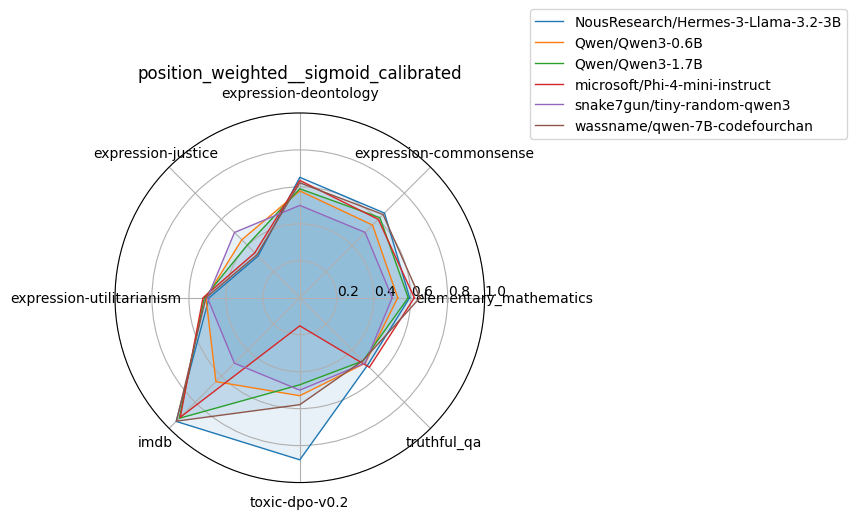

position_weighted__correct


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
NousResearch/Hermes-3-Llama-3.2-3B,0.595238,0.650165,0.666667,0.308239,0.482667,0.946667,0.889094,0.518667
Qwen/Qwen3-0.6B,0.526455,0.554455,0.580000,0.443182,0.505333,0.637333,0.532348,0.502667
Qwen/Qwen3-1.7B,0.584656,0.612211,0.589333,0.401989,0.516000,0.922667,0.469501,0.482667
microsoft/Phi-4-mini-instruct,0.624339,0.599010,0.637333,0.342330,0.513333,0.910667,0.153420,0.542667
snake7gun/tiny-random-qwen3,0.492063,0.501650,0.489333,0.464489,0.542667,0.520000,0.506469,0.490667
wassname/qwen-7B-codefourchan,0.645503,0.636964,0.620000,0.333807,0.501333,0.942667,0.582255,0.481333


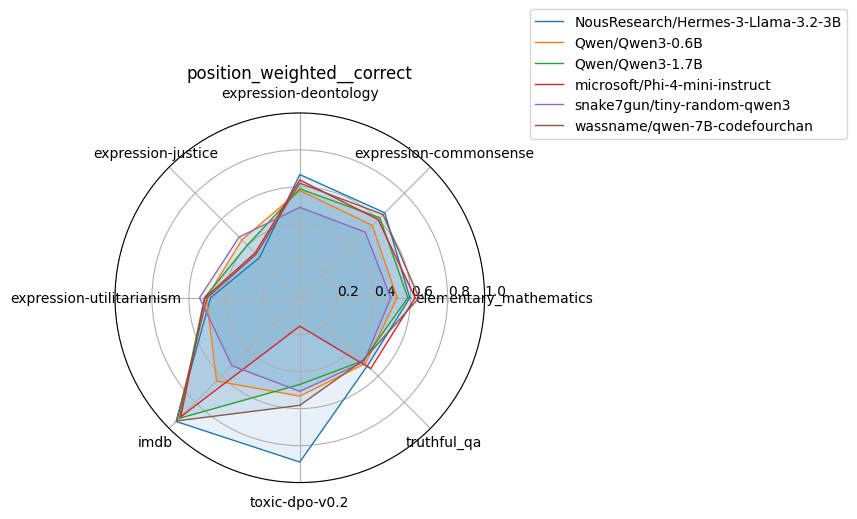

percentile__sigmoid_calibrated


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
NousResearch/Hermes-3-Llama-3.2-3B,0.605365,0.595591,0.620582,0.350083,0.510999,0.946667,0.966211,0.539802
Qwen/Qwen3-0.6B,0.532354,0.542484,0.560656,0.450795,0.524620,0.641997,0.902109,0.500448
Qwen/Qwen3-1.7B,0.557738,0.540908,0.580213,0.413015,0.514296,0.922667,0.560621,0.521545
microsoft/Phi-4-mini-instruct,0.601464,0.595759,0.613011,0.349189,0.551320,0.915018,0.487631,0.513126
snake7gun/tiny-random-qwen3,0.499851,0.500073,0.499986,0.499851,0.500055,0.500593,0.499836,0.500011
wassname/qwen-7B-codefourchan,0.660770,0.584650,0.615129,0.379909,0.551240,0.944667,0.790661,0.498224


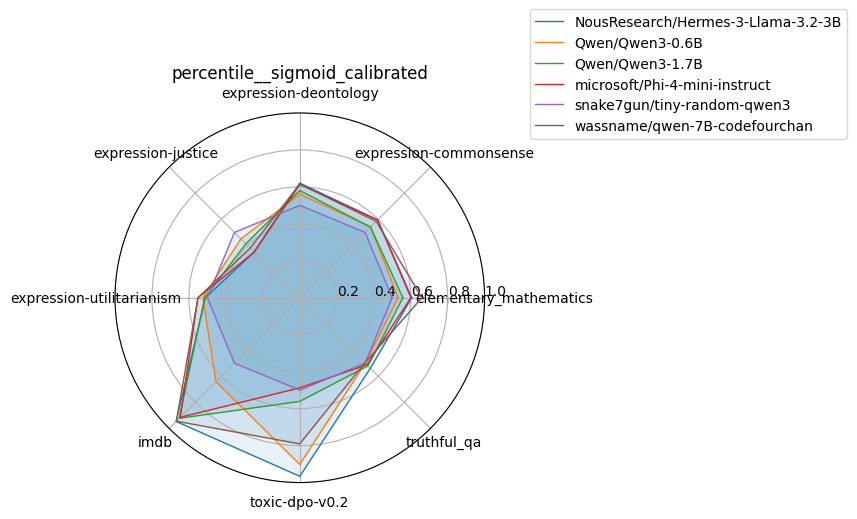

power_mean__sigmoid_calibrated


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
NousResearch/Hermes-3-Llama-3.2-3B,0.592336,0.615731,0.643599,0.340005,0.526642,0.946538,0.957791,0.556479
Qwen/Qwen3-0.6B,0.547360,0.572067,0.574299,0.451943,0.541280,0.641997,0.868268,0.514578
Qwen/Qwen3-1.7B,0.593864,0.577397,0.587625,0.416062,0.533622,0.922667,0.790190,0.508640
microsoft/Phi-4-mini-instruct,0.613739,0.623746,0.650247,0.339503,0.534986,0.915333,0.718250,0.551494
snake7gun/tiny-random-qwen3,0.499871,0.500041,0.499924,0.499706,0.500158,0.500593,0.499751,0.500057
wassname/qwen-7B-codefourchan,0.681312,0.613941,0.609709,0.341629,0.544567,0.944663,0.886430,0.497741


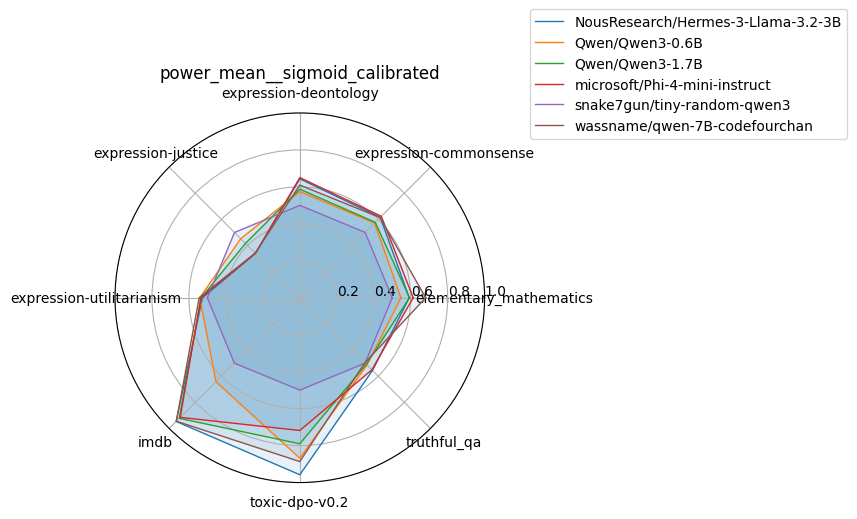

ipo__sigmoid_calibrated


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
NousResearch/Hermes-3-Llama-3.2-3B,0.596090,0.642349,0.655374,0.309741,0.504872,0.945707,0.958506,0.559008
Qwen/Qwen3-0.6B,0.532458,0.557642,0.585888,0.438458,0.526235,0.642036,0.914187,0.548918
Qwen/Qwen3-1.7B,0.596420,0.611463,0.603745,0.385672,0.523101,0.922667,0.917716,0.516934
microsoft/Phi-4-mini-instruct,0.636273,0.597155,0.648923,0.334042,0.537706,0.915268,0.913858,0.568278
snake7gun/tiny-random-qwen3,0.500002,0.500006,0.499945,0.499787,0.500064,0.500593,0.499809,0.499952
wassname/qwen-7B-codefourchan,0.646006,0.642239,0.631239,0.320652,0.528132,0.944666,0.960630,0.522628


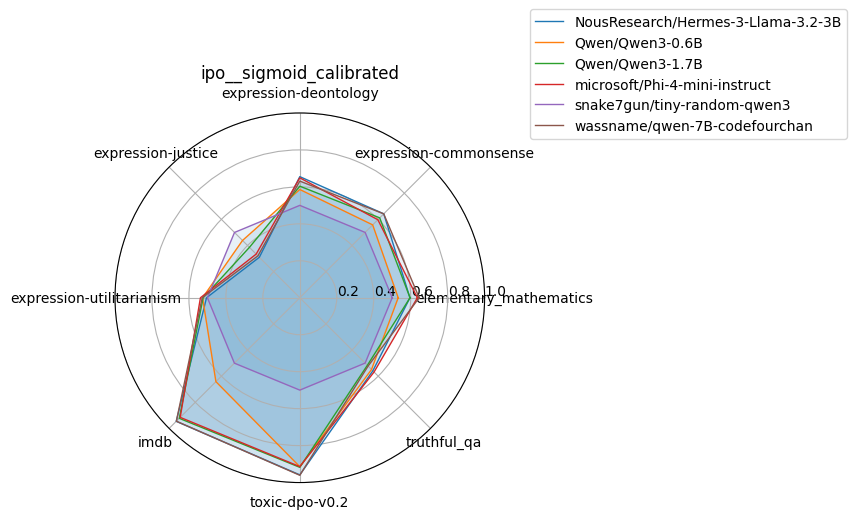

ipo__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
NousResearch/Hermes-3-Llama-3.2-3B,0.561860,0.594978,0.578740,0.385067,0.507424,0.936812,0.768997,0.527532
Qwen/Qwen3-0.6B,0.501294,0.546929,0.539346,0.460633,0.517977,0.616214,0.639454,0.520670
Qwen/Qwen3-1.7B,0.519042,0.575277,0.552440,0.429459,0.511550,0.905789,0.665516,0.515853
microsoft/Phi-4-mini-instruct,0.571053,0.569307,0.571565,0.400585,0.518941,0.897228,0.632456,0.536836
snake7gun/tiny-random-qwen3,0.502349,0.499272,0.495772,0.483138,0.509480,0.523108,0.482023,0.495723
wassname/qwen-7B-codefourchan,0.552215,0.580621,0.562037,0.395552,0.511252,0.915326,0.661603,0.503986


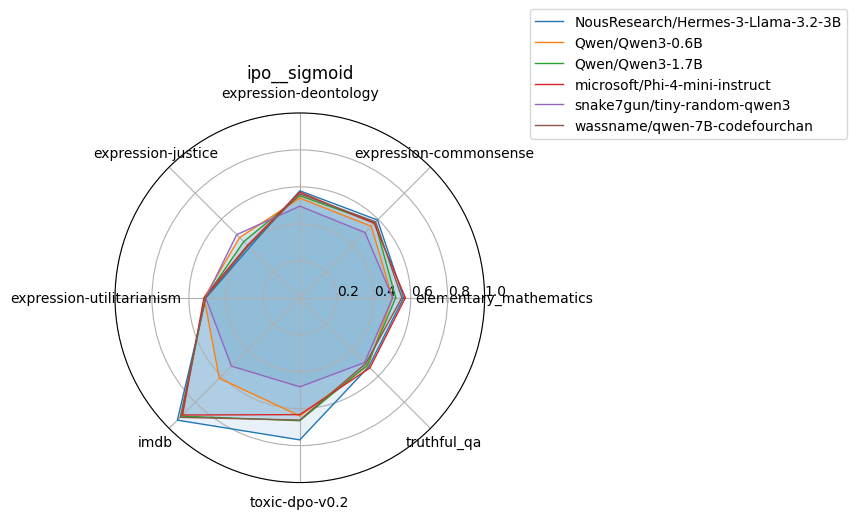

ipo__correct


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
NousResearch/Hermes-3-Llama-3.2-3B,0.600529,0.651815,0.677333,0.295455,0.493333,0.946667,0.968577,0.565333
Qwen/Qwen3-0.6B,0.531746,0.557756,0.585333,0.441761,0.526667,0.637333,0.916821,0.549333
Qwen/Qwen3-1.7B,0.595238,0.612211,0.604000,0.386364,0.522667,0.922667,0.916821,0.517333
microsoft/Phi-4-mini-instruct,0.640212,0.599010,0.650667,0.330966,0.534667,0.910667,0.913124,0.570667
snake7gun/tiny-random-qwen3,0.484127,0.498350,0.497333,0.465909,0.526667,0.520000,0.447320,0.486667
wassname/qwen-7B-codefourchan,0.642857,0.640264,0.632000,0.322443,0.528000,0.942667,0.963031,0.522667


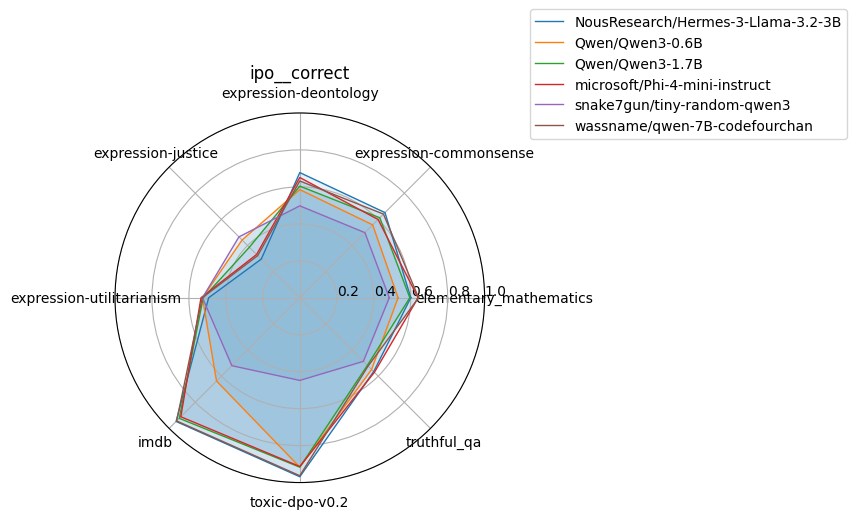

confidence_weighted__correct


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
NousResearch/Hermes-3-Llama-3.2-3B,0.584656,0.589109,0.554667,0.407670,0.525333,0.946667,0.966728,0.518667
Qwen/Qwen3-0.6B,0.531746,0.561056,0.516000,0.470170,0.514667,0.637333,0.881701,0.485333
Qwen/Qwen3-1.7B,0.574074,0.546205,0.552000,0.423295,0.517333,0.373333,0.373383,0.510667
microsoft/Phi-4-mini-instruct,0.560847,0.584158,0.562667,0.416193,0.538667,0.101333,0.214418,0.504000
snake7gun/tiny-random-qwen3,0.462963,0.503300,0.501333,0.464489,0.514667,0.521333,0.589649,0.525333
wassname/qwen-7B-codefourchan,0.669312,0.584158,0.556000,0.430398,0.537333,0.942667,0.611830,0.490667


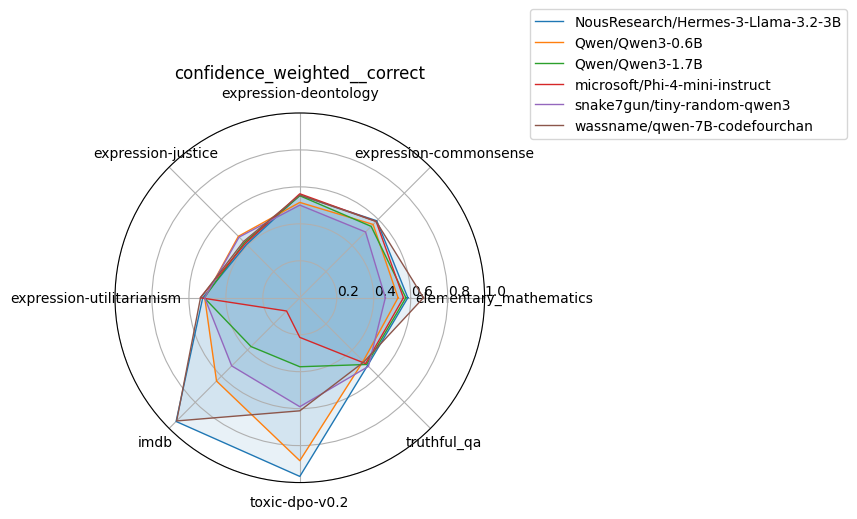

confidence_weighted__sigmoid_calibrated


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
NousResearch/Hermes-3-Llama-3.2-3B,0.585675,0.591630,0.555450,0.409582,0.525826,0.946667,0.966068,0.516905
Qwen/Qwen3-0.6B,0.540027,0.556029,0.516925,0.464829,0.517202,0.641997,0.874669,0.489591
Qwen/Qwen3-1.7B,0.499828,0.500401,0.500151,0.499742,0.500032,0.489803,0.499955,0.499865
microsoft/Phi-4-mini-instruct,0.500802,0.500557,0.500236,0.499592,0.500071,0.470671,0.499845,0.499762
snake7gun/tiny-random-qwen3,0.495589,0.499949,0.498799,0.489448,0.498704,0.513177,0.512409,0.506874
wassname/qwen-7B-codefourchan,0.661185,0.583819,0.558828,0.432586,0.536669,0.944662,0.601922,0.489321


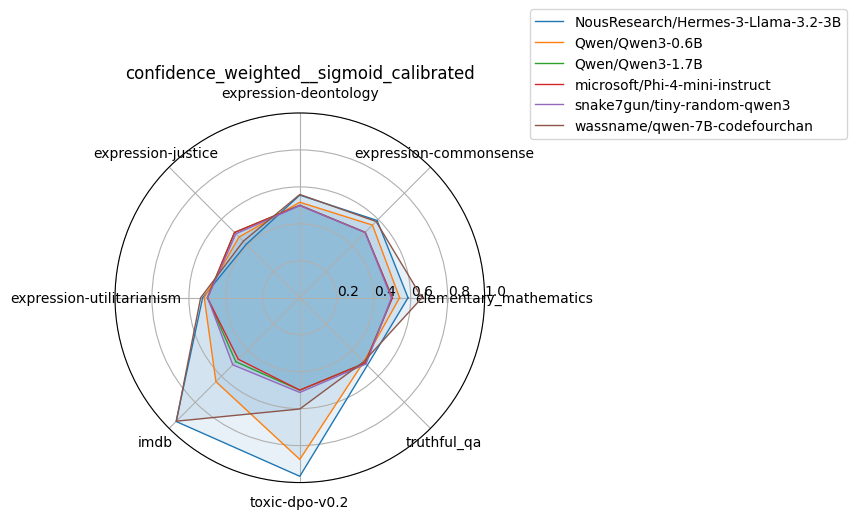

vocab_information_weighted__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
NousResearch/Hermes-3-Llama-3.2-3B,0.540247,0.554715,0.564344,0.431505,0.495825,0.936812,0.782846,0.507440
Qwen/Qwen3-0.6B,0.495882,0.520298,0.528198,0.489784,0.519542,0.616214,0.689687,0.491242
Qwen/Qwen3-1.7B,0.506111,0.536175,0.537031,0.462991,0.512528,0.905789,0.807157,0.506488
microsoft/Phi-4-mini-instruct,0.555377,0.532388,0.537043,0.444915,0.509833,0.897228,0.683283,0.485706
snake7gun/tiny-random-qwen3,0.500826,0.499017,0.497706,0.485488,0.510440,0.523108,0.490682,0.501045
wassname/qwen-7B-codefourchan,0.542383,0.548777,0.538164,0.438935,0.512879,0.915326,0.769131,0.481609


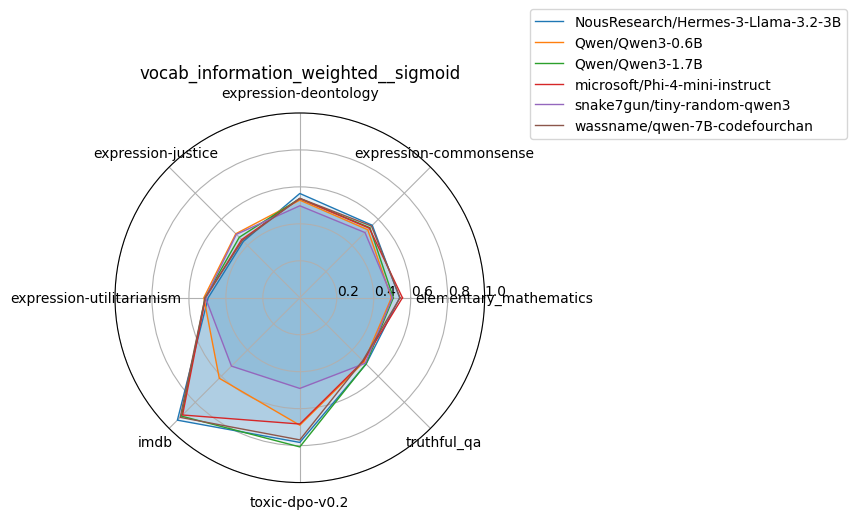

vocab_information_weighted__sigmoid_calibrated


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
NousResearch/Hermes-3-Llama-3.2-3B,0.541148,0.578133,0.641661,0.404460,0.493284,0.946667,0.967995,0.531683
Qwen/Qwen3-0.6B,0.517064,0.519917,0.546533,0.493742,0.516105,0.641997,0.936562,0.521275
Qwen/Qwen3-1.7B,0.510009,0.542498,0.550203,0.457366,0.519393,0.922614,0.957184,0.526017
microsoft/Phi-4-mini-instruct,0.572307,0.554668,0.580812,0.428857,0.515382,0.915333,0.942002,0.505827
snake7gun/tiny-random-qwen3,0.499960,0.500018,0.499958,0.499812,0.500073,0.500593,0.499903,0.500004
wassname/qwen-7B-codefourchan,0.566301,0.561684,0.572639,0.417320,0.513911,0.944514,0.962262,0.484540


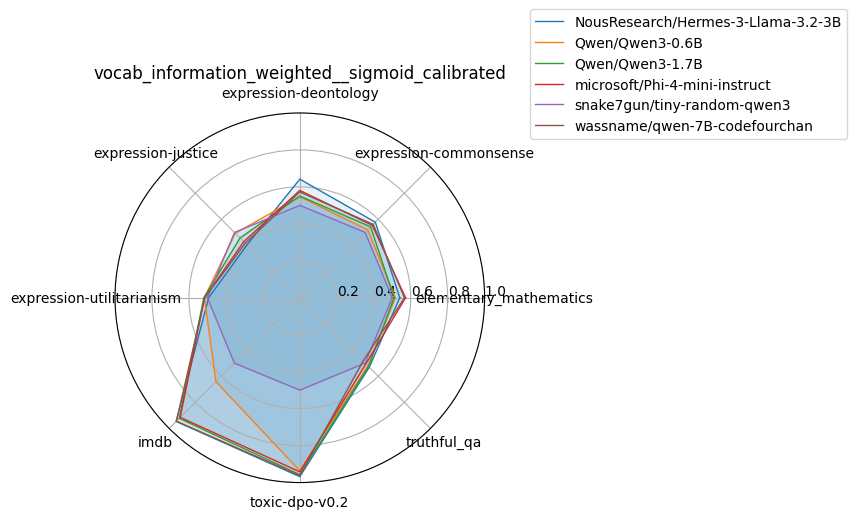

vocab_precision_weighted__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
NousResearch/Hermes-3-Llama-3.2-3B,0.540247,0.554715,0.564344,0.431505,0.495825,0.936812,0.782846,0.507440
Qwen/Qwen3-0.6B,0.495882,0.520298,0.528198,0.489784,0.519542,0.616214,0.689687,0.491242
Qwen/Qwen3-1.7B,0.506111,0.536175,0.537031,0.462991,0.512528,0.905789,0.807157,0.506488
microsoft/Phi-4-mini-instruct,0.555377,0.532388,0.537043,0.444915,0.509833,0.897228,0.683283,0.485706
snake7gun/tiny-random-qwen3,0.500826,0.499017,0.497706,0.485488,0.510440,0.523108,0.490682,0.501045
wassname/qwen-7B-codefourchan,0.542383,0.548777,0.538164,0.438935,0.512880,0.915326,0.769131,0.481609


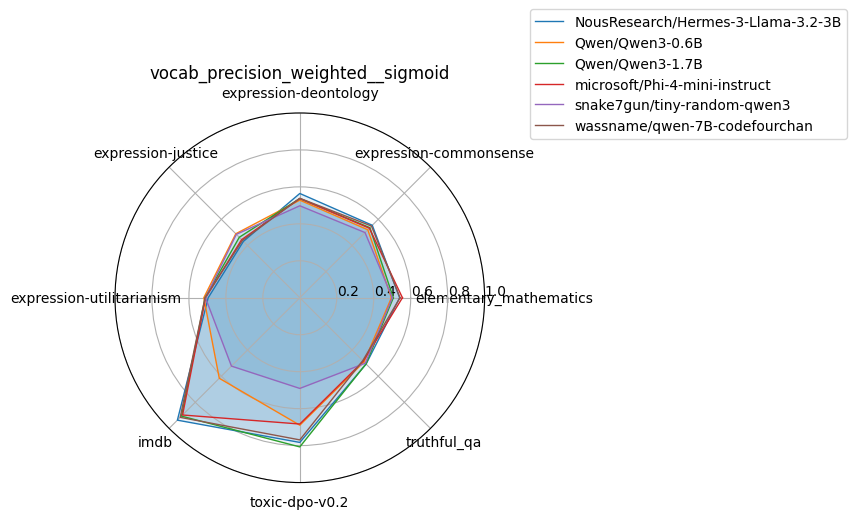

vocab_precision_weighted__sigmoid_calibrated


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
NousResearch/Hermes-3-Llama-3.2-3B,0.541148,0.578133,0.641661,0.404459,0.493284,0.946667,0.967995,0.531683
Qwen/Qwen3-0.6B,0.517064,0.519917,0.546533,0.493742,0.516105,0.641997,0.936562,0.521275
Qwen/Qwen3-1.7B,0.510009,0.542498,0.550203,0.457366,0.519393,0.922614,0.957184,0.526017
microsoft/Phi-4-mini-instruct,0.572307,0.554668,0.580812,0.428857,0.515382,0.915333,0.942002,0.505827
snake7gun/tiny-random-qwen3,0.499960,0.500018,0.499958,0.499812,0.500073,0.500593,0.499903,0.500004
wassname/qwen-7B-codefourchan,0.566301,0.561684,0.572639,0.417320,0.513911,0.944514,0.962262,0.484540


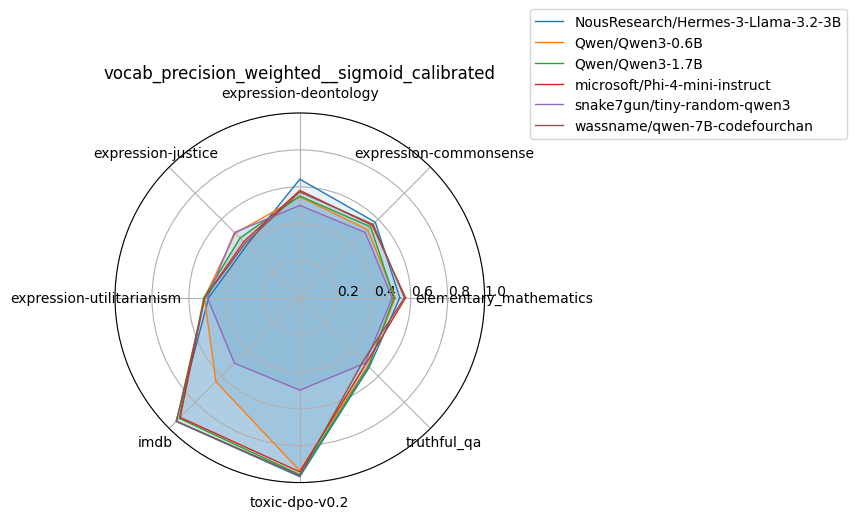

with_vocab_uncertainty__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
NousResearch/Hermes-3-Llama-3.2-3B,0.554811,0.576815,0.559342,0.408672,0.503616,0.935863,0.677094,0.509539
Qwen/Qwen3-0.6B,0.494333,0.538702,0.526223,0.475180,0.510901,0.570361,0.595094,0.512814
Qwen/Qwen3-1.7B,0.505840,0.568296,0.538758,0.445407,0.507532,0.903141,0.666758,0.500690
microsoft/Phi-4-mini-instruct,0.557127,0.557117,0.549954,0.428613,0.509940,0.895245,0.672037,0.527197
snake7gun/tiny-random-qwen3,0.500353,0.500637,0.498544,0.483635,0.506168,0.524046,0.502148,0.498578
wassname/qwen-7B-codefourchan,0.534037,0.568318,0.545339,0.419741,0.502840,0.914063,0.634053,0.494563


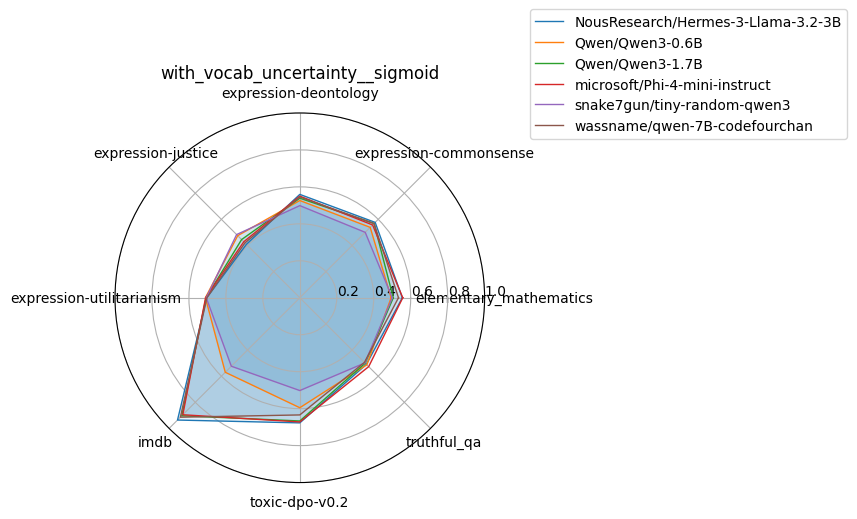

with_vocab_uncertainty__sigmoid_calibrated


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
NousResearch/Hermes-3-Llama-3.2-3B,0.607696,0.615341,0.632121,0.323441,0.501448,0.947265,0.950610,0.540704
Qwen/Qwen3-0.6B,0.522580,0.544596,0.562747,0.456089,0.510864,0.592533,0.893128,0.524021
Qwen/Qwen3-1.7B,0.547922,0.595144,0.579139,0.413613,0.513956,0.919227,0.909708,0.500993
microsoft/Phi-4-mini-instruct,0.612268,0.564285,0.613684,0.370810,0.514526,0.917486,0.958450,0.551833
snake7gun/tiny-random-qwen3,0.499934,0.499991,0.499972,0.499804,0.500058,0.500570,0.500016,0.499984
wassname/qwen-7B-codefourchan,0.629317,0.616905,0.602173,0.347384,0.511207,0.944185,0.957969,0.499028


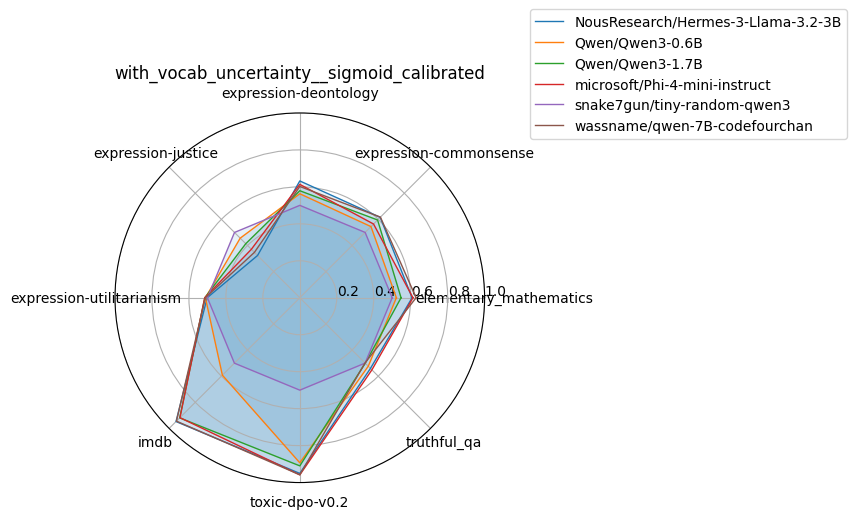

In [63]:
fav = [ "ipo__sigmoid_calibrated",
    "ipo__sigmoid",
    'ipo__correct',

     'confidence_weighted__correct',
       'confidence_weighted__sigmoid_calibrated',


"vocab_information_weighted__sigmoid",
"vocab_information_weighted__sigmoid_calibrated",

"vocab_precision_weighted__sigmoid",
"vocab_precision_weighted__sigmoid_calibrated",

"with_vocab_uncertainty__sigmoid",
"with_vocab_uncertainty__sigmoid_calibrated"]
cols = df_metrics.index[:4].tolist() + fav

for c in cols:
    # df2['correct2'] = df2[c]>0
    df_agg = df2.pivot_table(index='model', columns='dataset', values=c)
    print(c)
    display(df_agg)
    radar_plot(df_agg.T)
    plt.legend(loc='upper right', bbox_to_anchor=(2, 1.3))
    plt.title(c)
    plt.show()


# How many samples do we need?

In [64]:
from matplotlib import pyplot as plt

In [68]:
# methods = [
#     "ipo__sigmoid_calibrated",
#     "ipo__sigmoid",
#     'ipo__correct',

#      'confidence_weighted__correct',
#     #    'confidence_weighted__sigmoid_calibrated',


# "vocab_information_weighted__sigmoid",
# "vocab_precision_weighted__sigmoid",
# "with_vocab_uncertainty__sigmoid",
# "vocab_information_weighted__sigmoid_calibrated",
# "vocab_precision_weighted__sigmoid_calibrated",
# "with_vocab_uncertainty__sigmoid_calibrated",

#     #    'confidence_weighted__log_ratio_calibrated',

#     #           'with_vocab_uncertainty__log_ratio_calibrated',  
#     # 'position_weighted__sigmoid_calibrated',
#     #    'position_weighted__correct',
# ]
# # methods = df_metrics.index
# datasets = ['toxic-dpo-v0.2', 'imdb', 'truthful_qa', 'elementary_mathematics',
#        'expression-commonsense',]
# model = 'Qwen/Qwen3-1.7B'
# # Xs = sorted(set(np.logspace(1, np.log10(len(d)), 10).astype(int)))
# for dataset in datasets:
#     data = []
#     d = df2.query('dataset == @dataset and model == @model')
#     Xs = sorted(set(np.logspace(1, np.log10(len(d)), 25).astype(int)))
#     for method in methods:
#         for x in Xs:
#             v = np.abs(d[method].iloc[:x]-0.5)*2
#             mean = v.mean()
#             std =v.std()
#             data.append(dict(x=x, y=std/(1e-1+mean), mean=mean, std=std, method=method.replace('', '')))

#     data = pd.DataFrame(data)
#     for n,g in data.groupby('method'):
#         plt.plot(g['x'], g['mean'], label=n, marker='o', linestyle='-')
#     plt.xscale('log')
#     plt.xlabel('Number of samples')
#     plt.ylabel('Score')
#     plt.title(f'`{model}` `{dataset}`')
#     plt.legend()
#     plt.show()


In [69]:
def quick_sample_size(data1, data2, power=0.8, alpha=0.05):
    """Simple and fast calculation of sample size needed to distinguish two distributions"""
    import numpy as np
    from scipy.stats import ttest_ind
    from statsmodels.stats.power import ttest_power
    from scipy.optimize import brentq
    
    # Calculate effect size (Cohen's d)
    mean_diff = np.mean(data1) - np.mean(data2)
    pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
    effect_size = mean_diff / pooled_std if pooled_std > 0 else 0
    
    # Calculate required sample size by solving for n where power = target_power
    def power_at_n(n):
        return ttest_power(abs(effect_size), n, alpha) - power
    
    try:
        if abs(effect_size) < 1e-6:  # Very small effect size
            n_required = np.inf
        else:
            # Search for sample size between 5 and 10000
            n_required = brentq(power_at_n, 5, 10000)
    except (ValueError, RuntimeError):
        n_required = np.inf
    
    # Quick significance test with current data
    _, p_value = ttest_ind(data1, data2)
    
    return {
        'n_required': int(n_required) if n_required != np.inf else None,
        'effect_size': abs(effect_size),  # Take absolute value since direction doesn't matter
        'current_p': p_value,
        'current_significant': p_value < alpha,
        'current_n': min(len(data1), len(data2))
    }

def compare_models_quick(df, method, models, dataset):
    """Quick comparison of multiple models on a dataset using a scoring method"""
    results = []
    
    for i, model1 in enumerate(models):
        for model2 in models[i+1:]:
            data1 = df.query('dataset == @dataset and model == @model1')[method].dropna().values
            data2 = df.query('dataset == @dataset and model == @model2')[method].dropna().values
            
            if len(data1) > 5 and len(data2) > 5:  # Minimum viable sample
                result = quick_sample_size(data1, data2)
                result.update({
                    'model1': model1.split('/')[-1],
                    'model2': model2.split('/')[-1],
                    'method': method,
                    'dataset': dataset
                })
                results.append(result)
    
    return pd.DataFrame(results)

print("Simple sample size functions loaded!")

Simple sample size functions loaded!


In [81]:
# # Simple usage example
# model1 = 'microsoft/Phi-4-mini-instruct'
# model2 = 'snake7gun/tiny-random-qwen3'
# model2 = 'Qwen/Qwen3-0.6B'
# model2 = 'wassname/qwen-7B-codefourchan'
# method = 'ipo__correct'

# methods = [
#     "ipo__sigmoid_calibrated",
#     "ipo__sigmoid",
#     'ipo__correct',

#      'confidence_weighted__correct',
#        'confidence_weighted__sigmoid_calibrated',
#     'position_weighted__sigmoid_calibrated',
#        'position_weighted__correct',
#        'position_weighted__sigmoid',
#        'vocab_information_weighted__sigmoid', 'vocab_information_weighted__sigmoid_calibrated',
#                'vocab_precision_weighted__sigmoid', 'vocab_precision_weighted__sigmoid_calibrated',
#                'with_vocab_uncertainty__sigmoid', 'with_vocab_uncertainty__sigmoid_calibrated',]
# # methods = df_metrics.index
# datasets = ['toxic-dpo-v0.2', 'imdb', 'truthful_qa', 'elementary_mathematics',
#        'expression-commonsense',]
# dataset = 'elementary_mathematics'


# # Calculate required sample size
# results = []
# for method in methods:
#     # Get data for two models
#     data1 = df2.query('dataset == @dataset and model == @model1')[method].values
#     data2 = df2.query('dataset == @dataset and model == @model2')[method].values
#     for N in [10, 20, 50, 100, 200, 500, 1000, len(data2)]:
#         if N <= len(data1) and N <= len(data2):
#             data1_sample = data1[:N]
#             data2_sample = data2[:N]
#             result = quick_sample_size(data1_sample, data2_sample)
#             result['n_required'] = N
#             result['model1'] = model1.split('/')[-1]
#             result['model2'] = model2.split('/')[-1]
#             result['dataset'] = dataset
#             result['method'] = method
#             results.append(result)

# df_results = pd.DataFrame(results)

# # df_results = df_results.query('current_significant == True')
# df_results.pivot_table(index='n_required', columns='method', values='effect_size', aggfunc='mean').plot()
# plt.ylabel('Effect Size (Cohen\'s d)')
# plt.title(f'Effect Size vs Sample Size for {model1} vs {model2} on {dataset}')
# plt.legend(loc='upper left', bbox_to_anchor=(1.3, 1))

# df_results

In [82]:


# # result = quick_sample_size(data1, data2)

# print(f"Comparing {model1.split('/')[-1]} vs {model2.split('/')[-1]} on {dataset}:")
# print(f"Current sample sizes: {len(data1)} vs {len(data2)}")
# print(f"Effect size (Cohen's d): {result['effect_size']:.3f}")
# print(f"Required sample size for 80% power: {result['n_required']}")
# print(f"Current p-value: {result['current_p']:.4f}")
# print(f"Currently significant: {result['current_significant']}")

# # Quick comparison across multiple models and methods
# test_models = ['Qwen/Qwen3-1.7B', 'opencompass/CompassJudger-1-7B-Instruct', 'snake7gun/tiny-random-qwen3']
# test_methods = ['ipo__correct', 'confidence_weighted__correct', 'ipo__sigmoid', 'ipo__sigmoid_calibrated',
#                 'vocab_information_weighted__sigmoid', 'vocab_information_weighted__sigmoid_calibrated',
#                'vocab_precision_weighted__sigmoid', 'vocab_precision_weighted__sigmoid_calibrated',
#                'with_vocab_uncertainty__sigmoid', 'with_vocab_uncertainty__sigmoid_calibrated',]

# for method in test_methods:
#     print(f"\n--- {method} ---")
#     comparison_df = compare_models_quick(df2, method, test_models, 'imdb')
#     if not comparison_df.empty:
#         display(comparison_df[['model1', 'model2', 'n_required', 'effect_size', 'current_significant']])
#     else:
#         print("No valid comparisons found")

## Quick Reference

**Effect Size (Cohen's d) Interpretation:**
- `< 0.2`: Very small - need large samples
- `0.2-0.5`: Small - moderate samples needed  
- `0.5-0.8`: Medium - reasonable samples
- `> 0.8`: Large - small samples sufficient

**Usage:**
```python
# For two arrays of data
result = quick_sample_size(data1, data2)
print(f"Need {result['n_required']} samples for 80% power")

# For comparing models on a dataset
comparison_df = compare_models_quick(df, method, models, dataset)
```

In [83]:
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp
from statsmodels.stats.power import ttest_power
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def cohens_d(x1, x2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.std(x1, ddof=1), np.std(x2, ddof=1)
    # Pooled standard deviation
    s_pooled = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
    return np.abs(np.mean(x1) - np.mean(x2)) / s_pooled

def calculate_sample_size_ttest(effect_size, power=0.8, alpha=0.05, ratio=1):
    """Calculate required sample size for t-test"""
    from scipy.optimize import brentq
    
    def power_at_n(n):
        return ttest_power(abs(effect_size), n, alpha) - power
    
    try:
        if abs(effect_size) < 1e-6:  # Very small effect size
            return np.inf
        else:
            # Search for sample size between 5 and 10000
            return brentq(power_at_n, 5, 10000)
    except (ValueError, RuntimeError):
        return np.inf

def bootstrap_distribution_difference(data1, data2, n_bootstrap=1000):
    """Bootstrap confidence interval for difference in means"""
    diff_means = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        diff_means.append(np.mean(sample1) - np.mean(sample2))
    return np.array(diff_means)

def sequential_power_analysis(data1, data2, max_samples=None, step=10, alpha=0.05, target_power=0.8):
    """Analyze statistical power as sample size increases"""
    if max_samples is None:
        max_samples = min(len(data1), len(data2))
    
    sample_sizes = range(step, max_samples + 1, step)
    results = []
    
    for n in sample_sizes:
        if n > len(data1) or n > len(data2):
            break
            
        # Take first n samples
        subset1 = data1[:n]
        subset2 = data2[:n]
        
        # Calculate effect size
        effect_size = cohens_d(subset1, subset2)
        
        # Statistical tests
        t_stat, t_p = ttest_ind(subset1, subset2)
        u_stat, u_p = mannwhitneyu(subset1, subset2, alternative='two-sided')
        ks_stat, ks_p = ks_2samp(subset1, subset2)
        
        # Calculate achieved power
        achieved_power = ttest_power(effect_size, n, alpha) if not np.isnan(effect_size) else 0
        
        results.append({
            'n': n,
            'effect_size': effect_size,
            'ttest_p': t_p,
            'mannwhitney_p': u_p,
            'ks_p': ks_p,
            'achieved_power': achieved_power,
            'significant_ttest': t_p < alpha,
            'significant_mw': u_p < alpha,
            'significant_ks': ks_p < alpha
        })
    
    return pd.DataFrame(results)

def find_minimum_sample_size(data1, data2, target_power=0.8, alpha=0.05, max_samples=None):
    """Find minimum sample size needed to achieve target statistical power"""
    if max_samples is None:
        max_samples = min(len(data1), len(data2))
    
    # Calculate overall effect size
    overall_effect_size = cohens_d(data1, data2)
    
    # Theoretical minimum sample size
    theoretical_n = calculate_sample_size_ttest(overall_effect_size, target_power, alpha)
    
    # Empirical analysis
    power_df = sequential_power_analysis(data1, data2, max_samples)
    
    # Find first sample size that achieves target power
    empirical_n = None
    if not power_df.empty:
        sufficient_power = power_df[power_df['achieved_power'] >= target_power]
        if not sufficient_power.empty:
            empirical_n = sufficient_power['n'].iloc[0]
    
    return {
        'theoretical_n': theoretical_n,
        'empirical_n': empirical_n,
        'overall_effect_size': overall_effect_size,
        'power_analysis': power_df
    }

# Example usage with your scoring methods
def analyze_method_distinguishability(df, methods, models, dataset, target_power=0.8):
    """Analyze how many samples needed to distinguish between models using different scoring methods"""
    results = {}
    
    for method in tqdm(methods):
        print(f"\nAnalyzing method: {method}")
        method_results = {}
        
        # Get data for this dataset and method
        data = df.query('dataset == @dataset')[['model', method]].dropna()
        
        # Compare each pair of models
        for i, model1 in enumerate(models):
            for model2 in models[i+1:]:
                data1 = data[data['model'] == model1][method].values
                data2 = data[data['model'] == model2][method].values
                
                if len(data1) > 10 and len(data2) > 10:  # Minimum sample size
                    analysis = find_minimum_sample_size(data1, data2, target_power)
                    
                    method_results[f"{model1} vs {model2}"] = {
                        'theoretical_n': analysis['theoretical_n'],
                        'empirical_n': analysis['empirical_n'],
                        'effect_size': analysis['overall_effect_size']
                    }
        
        results[method] = method_results
    
    return results

print("Statistical power analysis functions loaded!")

Statistical power analysis functions loaded!


In [84]:
# Example: Analyze distinguishability between models for each scoring method

# Select a subset of models to compare
test_models = ['Qwen/Qwen3-1.7B', 'opencompass/CompassJudger-1-7B-Instruct', 'snake7gun/tiny-random-qwen3']
test_methods = ['ipo__correct', 'confidence_weighted__correct', 'ipo__sigmoid', 'ipo__sigmoid_calibrated',
                'vocab_information_weighted__sigmoid', 'vocab_information_weighted__sigmoid_calibrated',
               'vocab_precision_weighted__sigmoid', 'vocab_precision_weighted__sigmoid_calibrated',
               'with_vocab_uncertainty__sigmoid', 'with_vocab_uncertainty__sigmoid_calibrated',]

test_dataset = 'imdb'

# Run the analysis
distinguishability_results = analyze_method_distinguishability(
    df2, test_methods, test_models, test_dataset, target_power=0.8
)

# Display results
for method, comparisons in tqdm(distinguishability_results.items()):
    print(f"\n{'='*50}")
    print(f"Method: {method}")
    print(f"{'='*50}")
    
    for comparison, stats in comparisons.items():
        print(f"\n{comparison}:")
        print(f"  Effect size (Cohen's d): {stats['effect_size']:.3f}")
        print(f"  Theoretical sample size needed: {stats['theoretical_n']:.0f}" if not np.isnan(stats['theoretical_n']) else "  Theoretical sample size: Cannot calculate")
        print(f"  Empirical sample size needed: {stats['empirical_n']}" if stats['empirical_n'] else "  Empirical sample size: >max available")
        
        # Interpret effect size
        effect_size = abs(stats['effect_size'])
        if effect_size < 0.2:
            interpretation = "very small"
        elif effect_size < 0.5:
            interpretation = "small"
        elif effect_size < 0.8:
            interpretation = "medium"
        else:
            interpretation = "large"
        print(f"  Effect size interpretation: {interpretation}")

  0%|          | 0/10 [00:00<?, ?it/s]


Analyzing method: ipo__correct

Analyzing method: confidence_weighted__correct


/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Analyzing method: ipo__sigmoid

Analyzing method: ipo__sigmoid_calibrated


/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Analyzing method: vocab_information_weighted__sigmoid

Analyzing method: vocab_information_weighted__sigmoid_calibrated


/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Analyzing method: vocab_precision_weighted__sigmoid

Analyzing method: vocab_precision_weighted__sigmoid_calibrated


/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Analyzing method: with_vocab_uncertainty__sigmoid

Analyzing method: with_vocab_uncertainty__sigmoid_calibrated


/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


  0%|          | 0/10 [00:00<?, ?it/s]


Method: ipo__correct

Qwen/Qwen3-1.7B vs snake7gun/tiny-random-qwen3:
  Effect size (Cohen's d): 1.005
  Theoretical sample size needed: 10
  Empirical sample size needed: 10
  Effect size interpretation: large

Method: confidence_weighted__correct

Qwen/Qwen3-1.7B vs snake7gun/tiny-random-qwen3:
  Effect size (Cohen's d): 0.301
  Theoretical sample size needed: inf
  Empirical sample size needed: 20
  Effect size interpretation: small

Method: ipo__sigmoid

Qwen/Qwen3-1.7B vs snake7gun/tiny-random-qwen3:
  Effect size (Cohen's d): 1.166
  Theoretical sample size needed: inf
  Empirical sample size needed: 10
  Effect size interpretation: large

Method: ipo__sigmoid_calibrated

Qwen/Qwen3-1.7B vs snake7gun/tiny-random-qwen3:
  Effect size (Cohen's d): 2.232
  Theoretical sample size needed: inf
  Empirical sample size needed: 10
  Effect size interpretation: large

Method: vocab_information_weighted__sigmoid

Qwen/Qwen3-1.7B vs snake7gun/tiny-random-qwen3:
  Effect size (Cohen's d): 1

In [161]:
models

['snake7gun/tiny-random-qwen3',
 'Qwen/Qwen3-0.6B',
 'Qwen/Qwen3-1.7B',
 'NousResearch/Hermes-3-Llama-3.2-3B',
 'microsoft/Phi-4-mini-instruct',
 'wassname/qwen-7B-codefourchan']

In [162]:
# Summary function for analyzing all methods at once
def summarize_sample_requirements(df, datasets, models, methods, target_power=0.7):
    """Summarize sample size requirements across methods and datasets"""
    summary_results = []
    
    for dataset in datasets:
        for method in methods:
            print(f"Analyzing {method} on {dataset}...")
            
            # Get data for this combination
            data = df.query('dataset == @dataset')[['model', method]].dropna()
            
            if len(data) == 0:
                continue
                
            # Calculate pairwise comparisons
            method_samples = []
            for i, model1 in enumerate(tqdm(models)):
                for model2 in models[i+1:]:
                    data1 = data[data['model'] == model1][method].values
                    data2 = data[data['model'] == model2][method].values
                    
                    if len(data1) > 10 and len(data2) > 10:
                        analysis = find_minimum_sample_size(data1, data2, target_power)
                        
                        if not np.isnan(analysis['theoretical_n']):
                            method_samples.append(analysis['theoretical_n'])
                            
                            summary_results.append({
                                'dataset': dataset,
                                'method': method,
                                'model1': model1.split('/')[-1],
                                'model2': model2.split('/')[-1],
                                'required_n': analysis['theoretical_n'],
                                'effect_size': abs(analysis['overall_effect_size']),
                                'empirical_n': analysis['empirical_n']
                            })
            
    return pd.DataFrame(summary_results)

# Run the summary analysis
test_datasets = ['imdb', 'toxic-dpo-v0.2', 'truthful_qa']
test_models = ['Qwen/Qwen3-1.7B', 'wassname/qwen-7B-codefourchan', 'snake7gun/tiny-random-qwen3']
test_methods = ['ipo__correct', 'confidence_weighted__correct', 'ipo__sigmoid', 'ipo__sigmoid_calibrated',
                'vocab_information_weighted__sigmoid', 'vocab_information_weighted__sigmoid_calibrated',
               'vocab_precision_weighted__sigmoid', 'vocab_precision_weighted__sigmoid_calibrated',
               'with_vocab_uncertainty__sigmoid', 'with_vocab_uncertainty__sigmoid_calibrated',]

summary_df = summarize_sample_requirements(df2, test_datasets, test_models, test_methods)

if not summary_df.empty:
    print("\nSample Size Requirements Summary:")
    print("=" * 60)
    
    # Show average requirements by method
    method_summary = summary_df.groupby('method').agg({
        'empirical_n': ['mean', 'median', 'min', 'max'],
        'effect_size': ['mean', 'min', 'max']
    }).round(1)
    
    print("\nBy Method:")
    display(method_summary)
    
    # Show by dataset
    dataset_summary = summary_df.groupby('dataset').agg({
        'empirical_n': ['mean', 'median', 'min', 'max'],
        'effect_size': ['mean', 'min', 'max']
    }).round(1)
    
    print("\nBy Dataset:")
    display(dataset_summary)
    
else:
    print("No valid comparisons found with the given parameters.")

Analyzing ipo__correct on imdb...


  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_3084765/3399666721.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return np.abs(np.mean(x1) - np.mean(x2)) / s_pooled
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


Analyzing confidence_weighted__correct on imdb...


  0%|          | 0/3 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Analyzing ipo__sigmoid on imdb...


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing ipo__sigmoid_calibrated on imdb...


  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_3084765/3399666721.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return np.abs(np.mean(x1) - np.mean(x2)) / s_pooled
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


Analyzing vocab_information_weighted__sigmoid on imdb...


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing vocab_information_weighted__sigmoid_calibrated on imdb...


  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_3084765/3399666721.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return np.abs(np.mean(x1) - np.mean(x2)) / s_pooled
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


Analyzing vocab_precision_weighted__sigmoid on imdb...


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing vocab_precision_weighted__sigmoid_calibrated on imdb...


  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_3084765/3399666721.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return np.abs(np.mean(x1) - np.mean(x2)) / s_pooled
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


Analyzing with_vocab_uncertainty__sigmoid on imdb...


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing with_vocab_uncertainty__sigmoid_calibrated on imdb...


  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_3084765/3399666721.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return np.abs(np.mean(x1) - np.mean(x2)) / s_pooled
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Analyzing ipo__correct on toxic-dpo-v0.2...


  0%|          | 0/3 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Analyzing confidence_weighted__correct on toxic-dpo-v0.2...


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing ipo__sigmoid on toxic-dpo-v0.2...


/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing ipo__sigmoid_calibrated on toxic-dpo-v0.2...


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing vocab_information_weighted__sigmoid on toxic-dpo-v0.2...


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing vocab_information_weighted__sigmoid_calibrated on toxic-dpo-v0.2...


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing vocab_precision_weighted__sigmoid on toxic-dpo-v0.2...


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing vocab_precision_weighted__sigmoid_calibrated on toxic-dpo-v0.2...


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing with_vocab_uncertainty__sigmoid on toxic-dpo-v0.2...


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing with_vocab_uncertainty__sigmoid_calibrated on toxic-dpo-v0.2...


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing ipo__correct on truthful_qa...


  0%|          | 0/3 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


Analyzing confidence_weighted__correct on truthful_qa...


  0%|          | 0/3 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


Analyzing ipo__sigmoid on truthful_qa...


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing ipo__sigmoid_calibrated on truthful_qa...


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing vocab_information_weighted__sigmoid on truthful_qa...


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing vocab_information_weighted__sigmoid_calibrated on truthful_qa...


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing vocab_precision_weighted__sigmoid on truthful_qa...


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing vocab_precision_weighted__sigmoid_calibrated on truthful_qa...


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing with_vocab_uncertainty__sigmoid on truthful_qa...


  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing with_vocab_uncertainty__sigmoid_calibrated on truthful_qa...


  0%|          | 0/3 [00:00<?, ?it/s]


Sample Size Requirements Summary:

By Method:


empirical_n               \
                                                      mean median   min   
method                                                                    
confidence_weighted__correct                          20.0   20.0  10.0   
ipo__correct                                         114.3   10.0  10.0   
ipo__sigmoid                                         103.3   15.0  10.0   
ipo__sigmoid_calibrated                              117.1   10.0  10.0   
vocab_information_weighted__sigmoid                   86.2   15.0  10.0   
vocab_information_weighted__sigmoid_calibrated       247.1   10.0  10.0   
vocab_precision_weighted__sigmoid                     86.2   15.0  10.0   
vocab_precision_weighted__sigmoid_calibrated         247.1   10.0  10.0   
with_vocab_uncertainty__sigmoid                       13.3   10.0  10.0   
with_vocab_uncertainty__sigmoid_calibrated           120.0   15.0  10.0   

                                                      effect_size            
                                                  max        mean  min  max  
method                                                                       
confidence_weighted__correct                     30.0         0.4  0.0  1.5  
ipo__correct                                    650.0         0.6  0.0  1.4  
ipo__sigmoid                                    520.0         0.7  0.0  1.7  
ipo__sigmoid_calibrated                         630.0         1.2  0.0  3.5  
vocab_information_weighted__sigmoid             540.0         0.9  0.0  2.5  
vocab_information_weighted__sigmoid_calibrated  630.0         1.4  0.0  3.6  
vocab_precision_weighted__sigmoid               540.0         0.9  0.0  2.5  
vocab_precision_weighted__sigmoid_calibrated    630.0         1.4  0.0  3.6  
with_vocab_uncertainty__sigmoid                  30.0         0.6  0.0  1.2  
with_vocab_uncertainty__sigmoid_calibrated      590.0         1.3  0.0  3.8


By Dataset:


empirical_n                     effect_size          
                      mean median   min    max        mean  min  max
dataset                                                             
imdb                 113.0   10.0  10.0  650.0         1.2  0.0  2.8
toxic-dpo-v0.2        25.0   15.0  10.0   80.0         1.5  0.0  3.8
truthful_qa          358.2  500.0  40.0  560.0         0.0  0.0  0.1

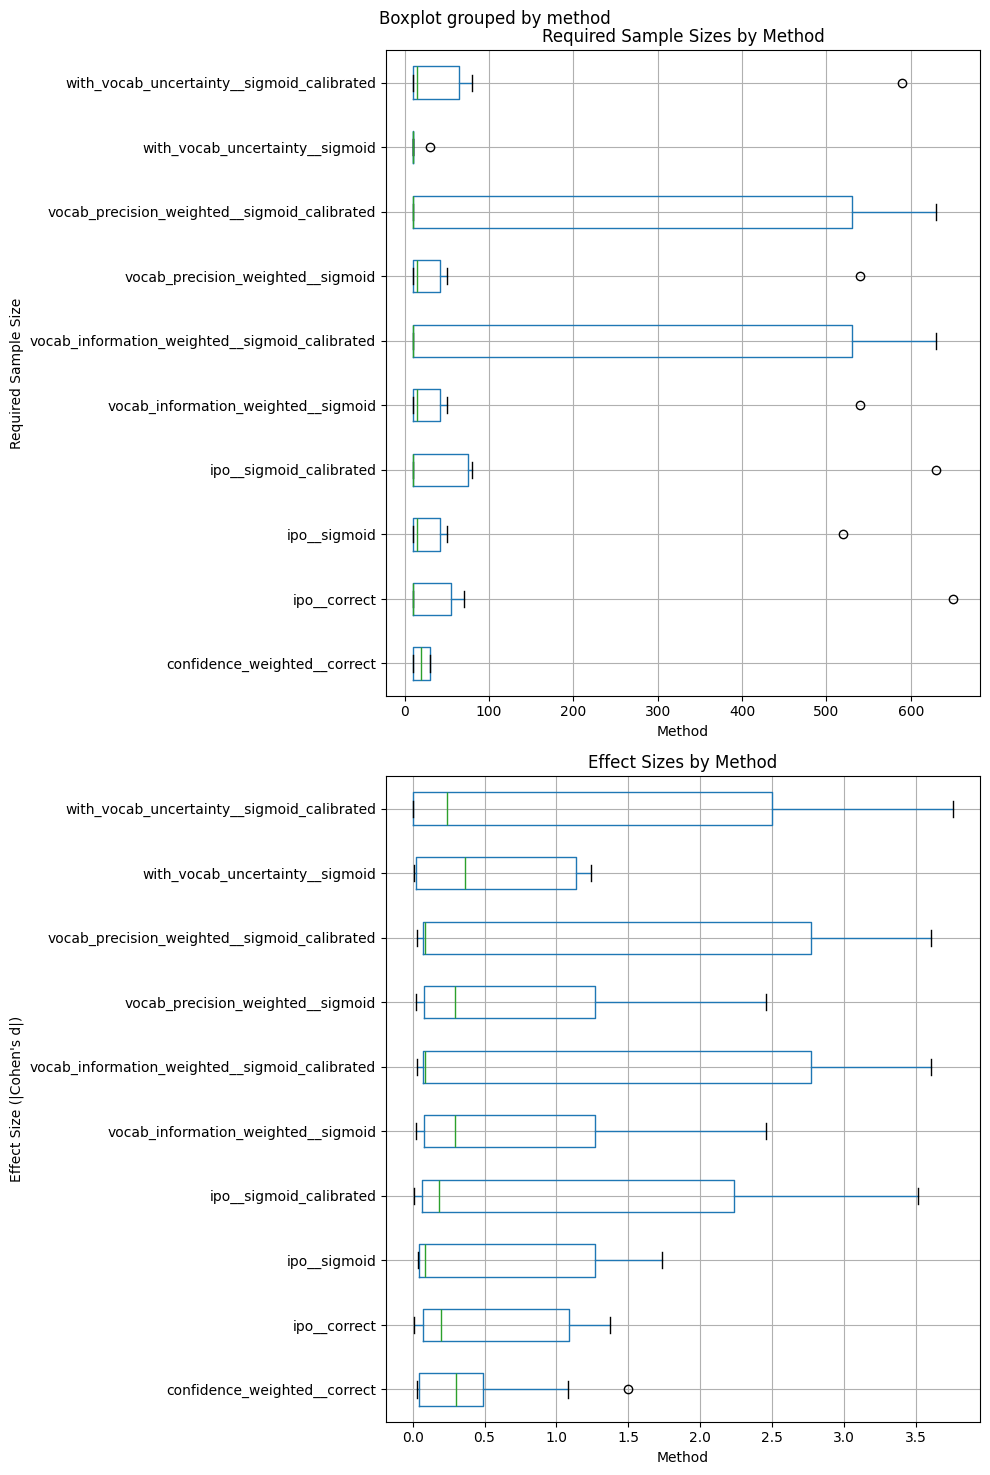

In [163]:

# Plot summary
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))

# Required sample sizes by method
summary_df.boxplot(column='empirical_n', by='method', ax=ax1, vert=False)
ax1.set_title('Required Sample Sizes by Method')
ax1.set_xlabel('Method')
ax1.set_ylabel('Required Sample Size')

# Effect sizes by method
summary_df.boxplot(column='effect_size', by='method', ax=ax2, vert=False)
ax2.set_title('Effect Sizes by Method')
ax2.set_xlabel('Method')
ax2.set_ylabel('Effect Size (|Cohen\'s d|)')

plt.tight_layout()
plt.show()

## Interpretation Guide

### Effect Size (Cohen's d)
- **< 0.2**: Very small effect - difficult to detect, large samples needed
- **0.2-0.5**: Small effect - moderate samples needed
- **0.5-0.8**: Medium effect - reasonable samples needed
- **> 0.8**: Large effect - small samples sufficient

### Sample Size Considerations
- **Theoretical N**: Based on Cohen's d and power calculation
- **Empirical N**: Based on actual sequential testing
- **Target Power**: 80% (standard) - probability of detecting true difference
- **Alpha Level**: 5% (standard) - probability of false positive

### Statistical Tests
- **t-test**: Assumes normal distributions, tests difference in means
- **Mann-Whitney U**: Non-parametric, tests difference in distributions
- **Kolmogorov-Smirnov**: Tests if distributions are different shapes

### Practical Guidelines
1. **For pilot studies**: Use 10-20% of calculated sample size
2. **For final evaluation**: Use full calculated sample size
3. **Multiple comparisons**: Apply Bonferroni correction (divide α by number of tests)
4. **Unequal variances**: Consider Welch's t-test instead of standard t-test

In [164]:
def plot_accuracy_convergence(df, methods, models, dataset, max_samples=None):
    """Plot how accuracy converges with sample size for different methods"""
    import numpy as np
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, method in enumerate(methods[:4]):  # Limit to 4 methods for visibility
        ax = axes[idx]
        
        for model in models:
            data = df.query('dataset == @dataset and model == @model')[method].dropna().values
            
            if len(data) < 5:  # Skip if too few samples
                continue
                
            if max_samples is None:
                max_samples = len(data)
            else:
                max_samples = min(max_samples, len(data))
            
            # Calculate cumulative accuracy at different sample sizes
            sample_sizes = np.logspace(.5, np.log10(max_samples), 35).astype(int)
            sample_sizes = np.unique(sample_sizes)  # Remove duplicates
            sample_sizes = sample_sizes[sample_sizes <= len(data)]
            
            accuracies = []
            for n in sample_sizes:
                # Calculate accuracy as percentage > 0.5 (or > 0 for log methods)
                threshold = 0.5 if not 'log' in method else 0
                acc = (data[:n]).mean()
                accuracies.append(acc)
            
            # Plot convergence curve
            ax.plot(sample_sizes, accuracies, marker='o', markersize=3, 
                   label=model.split('/')[-1], alpha=0.8)
        
        ax.set_xscale('log')
        ax.set_xlabel('Sample Size')
        ax.set_ylabel('Accuracy')
        ax.set_title(f'{method.replace("", "")} on {dataset}')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)
    
    # Hide unused subplots
    for idx in range(len(methods), 4):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_method_stability(df, methods, model, dataset, max_samples=None):
    """Plot how different methods converge for a single model on a dataset"""
    import numpy as np
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 6))
    
    for method in methods:
        data = df.query('dataset == @dataset and model == @model')[method].dropna().values
        
        if len(data) < 5:  # Skip if too few samples
            continue
            
        if max_samples is None:
            max_samples = len(data)
        else:
            max_samples = min(max_samples, len(data))
        # Calculate cumulative accuracy
        sample_sizes = np.logspace(.4, np.log10(max_samples), 25).astype(int)
        sample_sizes = np.unique(sample_sizes)
        sample_sizes = sample_sizes[sample_sizes <= len(data)]
        
        accuracies = []
        for n in sample_sizes:
            threshold = 0.5 if not 'log' in method else 0
            acc = (data[:n]).mean()
            accuracies.append(acc)
        
        plt.plot(sample_sizes, accuracies, marker='o', markersize=3, 
                label=method.replace('', ''), alpha=0.8)
    
    plt.xscale('log')
    plt.xlabel('Sample Size')
    plt.ylabel('Accuracy')
    plt.title(f'Method Convergence: {model.split("/")[-1]} on {dataset}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

def calculate_convergence_metrics(df, methods, models, dataset):
    """Calculate metrics about how quickly methods converge"""
    import numpy as np
    
    results = []
    
    for method in methods:
        for model in models:
            data = df.query('dataset == @dataset and model == @model')[method].dropna().values
            
            if len(data) < 5:  # Need reasonable sample size
                continue
            
            # Calculate convergence metrics
            threshold = 0.5 if not 'log' in method else 0
            final_acc = (data > threshold).mean()
            
            # Find sample size where accuracy stabilizes (within 5% of final)
            sample_sizes = np.logspace(.4, np.log10(len(data)), 35).astype(int)
            sample_sizes = np.unique(sample_sizes)
            
            stabilization_point = None
            for n in sample_sizes:
                acc = (data[:n]).mean()
                if abs(acc - final_acc) < 0.02:  # Within 2% of final accuracy
                    stabilization_point = n
                    break
            
            # Calculate variance in the last 50% of samples (stability measure)
            mid_point = len(data) // 2
            rolling_accs = []
            window = 5
            for i in range(mid_point, len(data) - window):
                acc = (data[i:i+window]).mean()
                rolling_accs.append(acc)
            
            stability = 1 / (1 + np.std(rolling_accs)) if rolling_accs else 0
            
            results.append({
                'method': method.replace('', ''),
                'model': model.split('/')[-1],
                'dataset': dataset,
                'final_accuracy': final_acc,
                'stabilization_point': stabilization_point,
                'stability_score': stability,
                'total_samples': len(data)
            })
    
    return pd.DataFrame(results)

print("Convergence analysis functions loaded!")

Convergence analysis functions loaded!


## Visual Convergence Analysis

The plots above show:

### 1. **Method Convergence Patterns**
- **Fast Converging**: Methods that stabilize quickly (< 50 samples)
- **Slow Converging**: Methods requiring more samples (> 100 samples) 
- **Unstable**: Methods with high variance even with many samples

### 2. **Model Differences**
- **Random models**: Should show flat convergence around 50% accuracy
- **Good models**: Should show rapid convergence to high accuracy
- **Poor models**: May show slow/unstable convergence

### 3. **Dataset Difficulty**
- **Easy datasets (IMDB)**: Fast convergence, high final accuracy
- **Hard datasets (TruthfulQA)**: Slower convergence, lower accuracy
- **Controversial datasets (Toxic)**: High variance, unstable convergence

### 4. **Practical Guidelines**
- Use **stabilization_point** to determine minimum sample sizes
- Choose methods with high **stability_score** for reliable evaluation
- Consider dataset difficulty when setting sample size requirements

In [165]:
df2

,model,dataset,ds_i,correct,prob,1st_diverg__sigmoid,1st_diverg__log_ratio,1st_diverg__correct,1st_diverg__chosen_log_score,1st_diverg__rejected_log_score,...,log_prob_sum__sigmoid_calibrated,percentile__sigmoid_calibrated,perplexity_ratio__sigmoid_calibrated,position_weighted__sigmoid_calibrated,power_mean__sigmoid_calibrated,preferences__sigmoid_calibrated,rank_based__sigmoid_calibrated,vocab_information_weighted__sigmoid_calibrated,vocab_precision_weighted__sigmoid_calibrated,with_vocab_uncertainty__sigmoid_calibrated
0,snake7gun/tiny-random-qwen3,toxic-dpo-v0.2,0,False,0.421926,0.132964,-1.8750,0.0,-14.8750,-13.0000,...,0.442688,5.003516e-01,4.994440e-01,0.499813,5.006778e-01,0.442688,0.500170,4.990392e-01,4.990392e-01,4.992128e-01
1,snake7gun/tiny-random-qwen3,toxic-dpo-v0.2,1,False,0.278947,0.955319,3.0625,1.0,-12.5625,-15.6250,...,0.442688,4.978906e-01,4.981538e-01,0.499318,4.988530e-01,0.442688,0.499342,4.974485e-01,4.974485e-01,4.976258e-01
2,snake7gun/tiny-random-qwen3,toxic-dpo-v0.2,2,True,0.518808,0.851953,1.7500,1.0,-10.7500,-12.5000,...,0.442688,5.000000e-01,5.003369e-01,0.501632,4.997698e-01,0.442688,0.499983,4.997678e-01,4.997678e-01,5.001882e-01
3,snake7gun/tiny-random-qwen3,toxic-dpo-v0.2,3,False,0.457735,0.924142,2.5000,1.0,-13.0000,-15.5000,...,0.442688,5.001563e-01,4.998583e-01,0.500609,4.996956e-01,0.442688,0.499901,5.003279e-01,5.003279e-01,4.995763e-01
4,snake7gun/tiny-random-qwen3,toxic-dpo-v0.2,4,False,0.479973,0.977023,3.7500,1.0,-12.0000,-15.7500,...,0.442688,4.985938e-01,5.000623e-01,0.500622,4.992059e-01,0.442688,0.499890,5.011175e-01,5.011175e-01,4.997996e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5224,wassname/qwen-7B-codefourchan,expression-deontology,745,True,0.529872,0.968856,3.4375,1.0,-10.0000,-13.4375,...,0.482850,1.875068e-33,1.000000e+00,0.999275,1.109157e-11,0.482850,0.969289,1.000000e+00,1.000000e+00,9.352817e-01
5225,wassname/qwen-7B-codefourchan,expression-deontology,746,True,0.605119,0.500000,0.0000,0.0,-13.2500,-13.2500,...,0.557312,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.557312,1.000000,3.468274e-14,3.468814e-14,9.999273e-01
5226,wassname/qwen-7B-codefourchan,expression-deontology,747,False,0.328839,0.500000,0.0000,0.0,-13.2500,-13.2500,...,0.485903,1.000000e+00,1.912228e-07,0.680818,9.930911e-01,0.485903,0.277461,1.919518e-24,1.919980e-24,1.209261e-07
5227,wassname/qwen-7B-codefourchan,expression-deontology,748,False,0.476580,0.500000,0.0000,0.0,-12.4375,-12.4375,...,0.489109,2.626046e-10,3.402949e-01,0.934923,1.039588e-01,0.489109,0.967595,9.999993e-01,9.999993e-01,1.097756e-01


In [168]:
datasets

['toxic-dpo-v0.2',
 'imdb',
 'truthful_qa',
 'elementary_mathematics',
 'expression-commonsense']

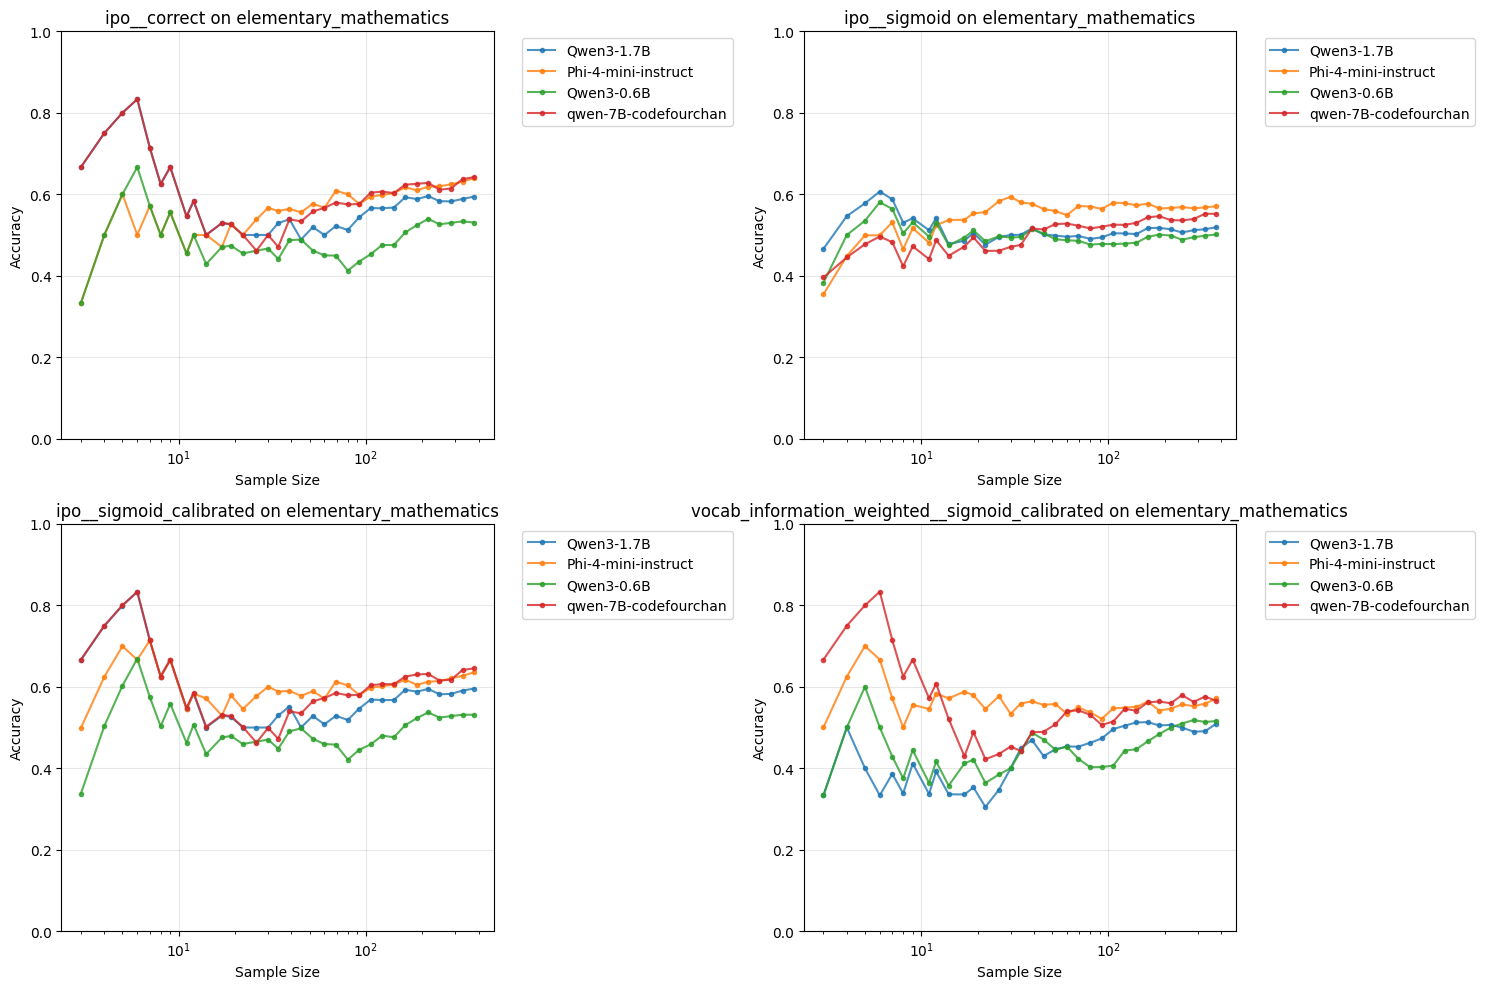

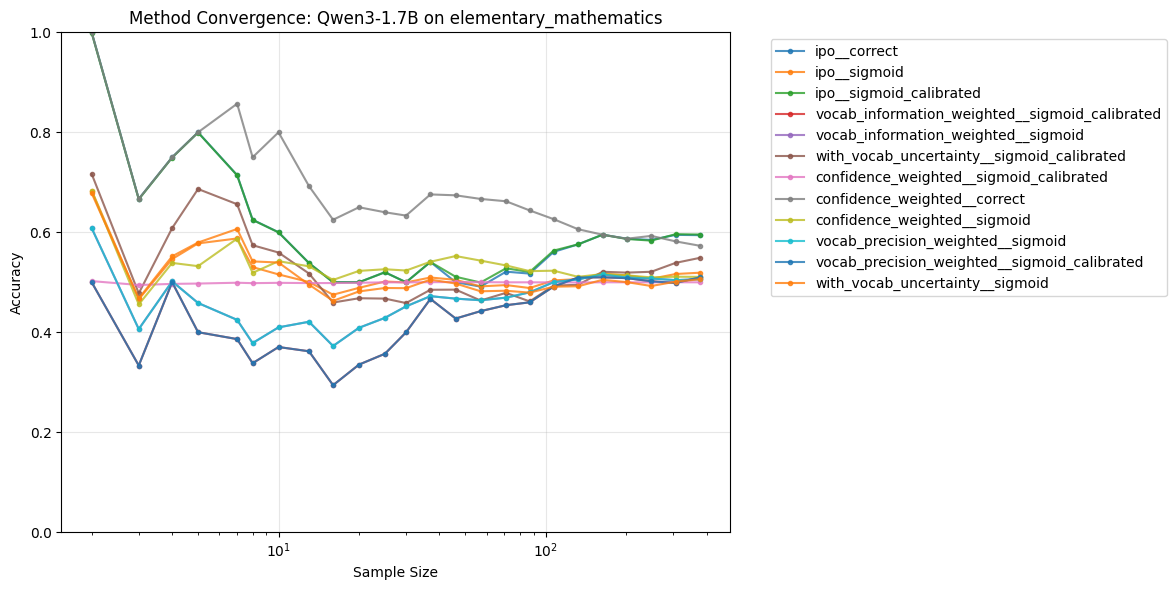


Convergence Metrics:


,method,model,dataset,final_accuracy,stabilization_point,stability_score,total_samples
24,confidence_weighted__sigmoid_calibrated,Qwen3-1.7B,elementary_mathematics,0.574074,NaN,0.997092,378
25,confidence_weighted__sigmoid_calibrated,Phi-4-mini-instruct,elementary_mathematics,0.560847,NaN,0.994063,378
34,confidence_weighted__sigmoid,Qwen3-0.6B,elementary_mathematics,0.531746,6.0,0.919895,378
35,confidence_weighted__sigmoid,qwen-7B-codefourchan,elementary_mathematics,0.669312,NaN,0.914983,378
46,with_vocab_uncertainty__sigmoid,Qwen3-0.6B,elementary_mathematics,0.521164,2.0,0.913750,378
6,ipo__sigmoid,Qwen3-0.6B,elementary_mathematics,0.531746,5.0,0.911356,378
32,confidence_weighted__sigmoid,Qwen3-1.7B,elementary_mathematics,0.574074,7.0,0.911276,378
4,ipo__sigmoid,Qwen3-1.7B,elementary_mathematics,0.595238,5.0,0.911258,378
44,with_vocab_uncertainty__sigmoid,Qwen3-1.7B,elementary_mathematics,0.544974,4.0,0.910631,378
47,with_vocab_uncertainty__sigmoid,qwen-7B-codefourchan,elementary_mathematics,0.629630,NaN,0.900308,378



Method Summary:


stabilization_point         \
                                                              mean median   
method                                                                      
confidence_weighted__correct                                 60.00   40.5   
confidence_weighted__sigmoid                                  6.50    6.5   
confidence_weighted__sigmoid_calibrated                      10.00   10.0   
ipo__correct                                                131.00   95.0   
ipo__sigmoid                                                  5.00    5.0   
ipo__sigmoid_calibrated                                      50.50    9.0   
vocab_information_weighted__sigmoid                          15.50   11.5   
vocab_information_weighted__sigmoid_calibrated               18.75    4.5   
vocab_precision_weighted__sigmoid                            51.75   11.5   
vocab_precision_weighted__sigmoid_calibrated                 18.75    4.5   
with_vocab_uncertainty__sigmoid                               3.00    3.0   
with_vocab_uncertainty__sigmoid_calibrated                  137.50  109.5   

                                                         stability_score  \
                                                     std            mean   
method                                                                     
confidence_weighted__correct                     69.1134          0.8109   
confidence_weighted__sigmoid                      0.7071          0.9109   
confidence_weighted__sigmoid_calibrated           9.8995          0.9069   
ipo__correct                                    152.9662          0.8228   
ipo__sigmoid                                      0.0000          0.8988   
ipo__sigmoid_calibrated                          86.3694          0.8259   
vocab_information_weighted__sigmoid              14.2009          0.8832   
vocab_information_weighted__sigmoid_calibrated   30.2586          0.8157   
vocab_precision_weighted__sigmoid                85.6908          0.8832   
vocab_precision_weighted__sigmoid_calibrated     30.2586          0.8157   
with_vocab_uncertainty__sigmoid                   1.4142          0.9014   
with_vocab_uncertainty__sigmoid_calibrated      157.5405          0.8356   

                                                       final_accuracy          
                                                   std           mean     std  
method                                                                         
confidence_weighted__correct                    0.0091         0.5840  0.0596  
confidence_weighted__sigmoid                    0.0097         0.5840  0.0596  
confidence_weighted__sigmoid_calibrated         0.1028         0.5840  0.0596  
ipo__correct                                    0.0073         0.6025  0.0520  
ipo__sigmoid                                    0.0154         0.6025  0.0520  
ipo__sigmoid_calibrated                         0.0083         0.6025  0.0520  
vocab_information_weighted__sigmoid             0.0150         0.5410  0.0338  
vocab_information_weighted__sigmoid_calibrated  0.0119         0.5410  0.0338  
vocab_precision_weighted__sigmoid               0.0150         0.5417  0.0331  
vocab_precision_weighted__sigmoid_calibrated    0.0119         0.5417  0.0331  
with_vocab_uncertainty__sigmoid                 0.0148         0.5767  0.0519  
with_vocab_uncertainty__sigmoid_calibrated      0.0098         0.5767  0.0519

In [179]:
# Example: Visualize accuracy convergence for different methods

# 1. Show how different models converge on IMDB using key methods
key_methods = ['ipo__correct',
               'ipo__sigmoid', 'ipo__sigmoid_calibrated',
                'vocab_information_weighted__sigmoid_calibrated',
               'vocab_information_weighted__sigmoid',

                'with_vocab_uncertainty__sigmoid_calibrated',
                'confidence_weighted__sigmoid_calibrated',
                'confidence_weighted__correct', 
                'confidence_weighted__sigmoid',

                
               'vocab_precision_weighted__sigmoid',
                'vocab_precision_weighted__sigmoid_calibrated',

               'with_vocab_uncertainty__sigmoid',
               ]
test_models = ['Qwen/Qwen3-1.7B', 'opencompass/CompassJudger-1-7B-Instruct',
                # 'snake7gun/tiny-random-qwen3'
                'microsoft/Phi-4-mini-instruct',
                'Qwen/Qwen3-0.6B', 'wassname/qwen-7B-codefourchan']

dataset = 'elementary_mathematics'
plot_accuracy_convergence(df2, key_methods, test_models, dataset, max_samples=760)

# 2. Compare method stability for a single model
plot_method_stability(df2, key_methods, 'Qwen/Qwen3-1.7B', dataset, max_samples=760)

# 3. Calculate convergence metrics
convergence_df = calculate_convergence_metrics(df2, key_methods, test_models, dataset).sort_values('stability_score', ascending=False)
print("\nConvergence Metrics:")
display(convergence_df)

# Summary by method
method_summary = convergence_df.groupby('method').agg({
    'stabilization_point': ['mean', 'median', 'std'],
    'stability_score': ['mean', 'std'],
    'final_accuracy': ['mean', 'std']
}).round(4)

print("\nMethod Summary:")
display(method_summary)

In [167]:
# # Cross-dataset convergence comparison
# test_datasets = ['imdb', 'toxic-dpo-v0.2', 'truthful_qa']
# test_method = 'ipo__correct'
# test_model = 'Qwen/Qwen3-1.7B'

# plt.figure(figsize=(12, 6))

# for dataset in test_datasets:
#     data = df2.query('dataset == @dataset and model == @test_model')[test_method].dropna().values
    
#     if len(data) < 20:
#         continue
    
#     # Calculate cumulative accuracy
#     max_samples = min(400, len(data))
#     sample_sizes = np.logspace(1, np.log10(max_samples), 25).astype(int)
#     sample_sizes = np.unique(sample_sizes)
#     sample_sizes = sample_sizes[sample_sizes <= len(data)]
    
#     accuracies = []
#     for n in sample_sizes:
#         acc = (data[:n] > 0.5).mean()
#         accuracies.append(acc)
    
#     plt.plot(sample_sizes, accuracies, marker='o', markersize=3, 
#             label=dataset, alpha=0.8, linewidth=2)

# plt.xscale('log')
# plt.xlabel('Sample Size')
# plt.ylabel('Accuracy')
# plt.title(f'Dataset Convergence Comparison: {test_model.split("/")[-1]} using {test_method.replace("", "")}')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.ylim(0, 1)
# plt.tight_layout()
# plt.show()

# # Show convergence for toxic dataset (should be more variable)
# plot_method_stability(df2, key_methods, 'Qwen/Qwen3-1.7B', 'toxic-dpo-v0.2', max_samples=400)